# May ??th, 2021

**Motivation**: Comparison between individual and common spaces.  Comparison between Allen and k-means parcellation. </br>

In [1]:
# HIDE CODE


import re
import os
import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from os.path import join as pjoin
from scipy import stats as sp_stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
from utils.processing import *
from model.configuration import Config

In [2]:
# HIDE CODE


def filter_islands(partition, atlas, node_labels, min_com_size: int = 3):
    coms_ctr = collections.Counter(partition.values())
    
    good_com_idxs = zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common()))
    good_com_idxs = sorted(tuple(good_com_idxs)[0])
    bad_com_idxs = [item for item in set(partition.values()) if item not in good_com_idxs]

    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)
    comm_dict = dict(sorted(comm_dict.items()))

    comm_mat = np.ones(atlas.shape) * -1
    for node, com_idx in partition.items():
        region_id = node_labels[node]
        if com_idx in good_com_idxs:
            comm_mat[atlas == region_id] = good_com_idxs.index(com_idx)
        else:
            comm_mat[atlas == region_id] = np.nan
    
    output = {
        'good_com_idxs': good_com_idxs,
        'bad_com_idxs': bad_com_idxs,
        'comm_dict': comm_dict,
        'comm_mat': comm_mat,
    }
    return output


def plot_louvain_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    contour: np.ndarray,
    modularities: dict,
    selected_idxs: list,
    percentile: int = 20,
    min_com_size: int = 3,
    figsize=(12, 4.5),
    colorbar=False, ):

    x0, y0 = tuple(zip(*modularities.items()))
    best_idx = np.argmax(y0)
    best_res = x0[best_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [best_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        # pearson
        g = nx.from_numpy_matrix(pearson[percentile])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=min_com_size)
        q = nx_comm.modularity(g, communities=coms.communities)

        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[0, ii].imshow(data2plot, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[0, ii].set_title(msg, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[percentile])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=min_com_size)
        q = nx_comm.modularity(g, communities=coms.communities)
    
        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[1, ii].imshow(data2plot, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[1, ii].set_title(msg, y=1.03)
        

        if ii == 0:
            msg1 = 'pearson\n(th = {:.2f})\n'
            msg1 = msg1.format(np.min(pearson[percentile][pearson[percentile] > 0]))
            msg2 = 'spearman\n(th = {:.2f})\n'
            msg2 = msg2.format(np.min(spearman[percentile][spearman[percentile] > 0]))
            axes[0, ii].set_ylabel(msg1, fontsize=12)
            axes[1, ii].set_ylabel(msg2, fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



def plot_leiden_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    contour: np.ndarray,
    figsize=None,
    colorbar=False,):
    
    percentiles = list(spearman.keys())
    
    sns.set_style('white')
    figsize = (5.2, 2*len(percentiles)) if figsize is None else figsize
    fig, axes = plt.subplots(len(percentiles), 2, figsize=figsize)

    for ii, perc in enumerate(sorted(percentiles, reverse=True)):
        # pearson
        g = nx.from_numpy_matrix(pearson[perc])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)

        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[ii, 0].imshow(data2plot, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 0], shrink=0.9)
        if ii == 0:
            msg = 'Pearson\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 0].set_title(msg, fontsize=12, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[perc])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)
        
        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[ii, 1].imshow(data2plot, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 1], shrink=0.9)
        if ii == 0:
            msg = 'Spearman\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 1].set_title(msg, fontsize=12, y=1.03)
        axes[ii, 1].set_ylabel('Using {:d} {:s} \n'.format(perc, '%'), fontsize=12)
        
        for j in range(2):
            axes[ii, j].set_xticks([])
            axes[ii, j].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



from skimage.feature import canny
import functools


def organize_atlas(
    organized_data: dict,
    include: Union[range, List[int]] = None,
    config: Config = None,):
    
    config = Config() if config is None else config
    regions = np.unique(organized_data['atlas'])
    regions = {i: config.region_labels[i] for i in regions if i > 0}
    
    include = list(regions.keys())[:19] if include is None else include
    exclude = [item for item in regions if item not in include]
    mapping = {i+1: regions[item].split('(')[0].strip() for i, item in enumerate(include)}

    atlas = organized_data['atlas'].copy()
    cond = functools.reduce(np.logical_or, [atlas == r for r in exclude])
    x = np.ma.masked_where(cond, atlas)

    for i, true_i in zip(mapping, include):
        x[x == true_i] = i

    mapping[0] = 'background'
    mapping = dict(sorted(mapping.items()))

    contour = atlas.copy().astype(float)
    for i, true_i in enumerate(regions):
        contour[contour == true_i] = i
    contour = canny(contour, sigma=1e-10)

    output = {
        'regions': regions,
        'mapping': mapping,
        'atlas': atlas,
        'atlas_limited': x,
        'contour': contour,
    }
    return output

## Allen atlas visualization

In [3]:
config = Config()

subject = 6
session = 1
run = 1

load = load_organized_data(
    folder='atlas-allen_unfiltered_unnormalized',
    config=config,
    subject=subject,
    session=session,
    run=run,
)
atls_org = organize_atlas(load)

## Combine data

In [4]:
run = 1
regions = {}
tot_num_regions = {}
for subject in range(1, config.num_subjects+1):
    for session in range(1, config.num_sessions+1):
        _load = load_organized_data(
            folder='atlas-allen_unfiltered_unnormalized',
            config=config,
            subject=subject,
            session=session,
            run=run,
        )
        if _load is None:
            continue
        _atlsorg = organize_atlas(_load)
        key = 'sub-SLC{:02d}_ses-{:d}'.format(subject, session)
        regions[key] = _atlsorg['regions']
        tot_num_regions[key] = len(_atlsorg['regions'])

common_regions = list(set.intersection(*[set(reg_dict.keys()) for reg_dict in regions.values()]))
common_regions = {k: config.region_labels[k] for k in sorted(common_regions)}
common_r = [item[2:] for item in common_regions.values() if item[:2] == 'R-']
common_l = [item[2:] for item in common_regions.values() if item[:2] == 'L-']
common_global = set(common_r).intersection(common_l)
common_regions = {k: v for k, v in common_regions.items() if v[2:] in common_global}
len(common_regions)

44

In [5]:
[item[2:] for item in common_regions.values() if 'R-' in item]

['Primary motor area (MOp,985)',
 'Secondary motor area (MOs,993)',
 'Primary somatosensory area, nose (SSp-n,353)',
 'Primary somatosensory area, barrel field (SSp-bfd,329)',
 'Primary somatosensory area, lower limb (SSp-ll,337)',
 'Primary somatosensory area, mouth (SSp-m,345)',
 'Primary somatosensory area, upper limb (SSp-ul,369)',
 'Primary somatosensory area, trunk (SSp-tr,361)',
 'Primary somatosensory area, unassigned (SSp-un,182305689)',
 'Supplemental somatosensory area (SSs,378)',
 'Anterolateral visual area (VISal,402)',
 'Anteromedial visual area (VISam,394)',
 'Lateral visual area (VISl,409)',
 'Primary visual area (VISp,385)',
 'posteromedial visual area (VISpm,533)',
 'Anterior area (VISa,312782546)',
 'Rostrolateral visual area (VISrl,417)',
 'Anterior cingulate area, dorsal part (ACAd,39)',
 'Retrosplenial area, lateral agranular part (RSPagl,894)',
 'Retrosplenial area, dorsal part (RSPd,879)',
 'Retrosplenial area, ventral part (RSPv,886)',
 'Superior colliculus, su

In [6]:
atls_org = organize_atlas(load, include=common_regions)

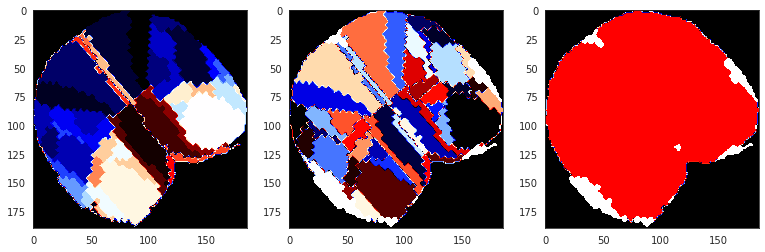

In [7]:
plt.figure(figsize=(13, 6))

plt.subplot(131)
plt.imshow(atls_org['atlas'], cmap='flag_r')

plt.subplot(132)
plt.imshow(atls_org['atlas_limited'], cmap='flag_r')

plt.subplot(133)
plt.imshow(atls_org['atlas_limited'] > 0, cmap='flag_r')

plt.show()

In [8]:
shared_field_names = ('mode', 'subject', 'session', 'run', 'norm', 'lowcut', 'highcut', 'bp_order')

field_names = shared_field_names + ('df', )
MouseDF = collections.namedtuple(typename='MouseDF', field_names=field_names)

field_names = shared_field_names + ('percentile', 'node_labels', 'a', 'g', 'cfg', )
MouseGraph = collections.namedtuple(typename='MouseGraph', field_names=field_names)

### Get MouseDF

In [9]:
# HIDE CODE


lowcut = 0.002
highcut = 0.9
order = 2

mode = 'ca'
df_all = {}

for subject in tqdm(range(1, config.num_subjects+1)):
    for session in range(1, config.num_sessions+1):
        for run in [1, 3, 5, 7]:
            cond_1 = subject == 3 and session == 2 and run in [2, 6]
            cond_2 = subject == 7 and session == 2 and run in [2, 7]
            if cond_1 or cond_2:
                continue

            _load = load_organized_data(
                folder='atlas-allen_unfiltered_unnormalized',
                config=config,
                subject=subject,
                session=session,
                run=run,
            )
            if _load is None:
                continue

            for k, v in _load['ca'].items():
                if np.isnan(v).sum():
                    print(subject, session, run, k)

            # bandpass
            ca = {k: v for k, v in _load['ca'].items()}
            ca_bp = {
                k: apply_bandpass(
                    x=v,
                    fs=config.ca_fs,
                    lowcut=lowcut,
                    highcut=highcut,
                    order=order, )
                for k, v in _load['ca'].items()
            }

            # normalize
            mean = np.mean([item.mean() for item in ca.values()])
            sd = np.mean([item.std() for item in ca.values()])
            ca_n = {k: (v - mean) / sd for k, v in ca.items()}
            
            mean = np.mean([item.mean() for item in ca_bp.values()])
            sd = np.mean([item.std() for item in ca_bp.values()])
            ca_bp_n = {k: (v - mean) / sd for k, v in ca_bp.items()}
            
            # prepare to store data
            key = 'mode-{:s}_sub-SLC{:02d}'.format(mode, subject)
            key += '_ses-{:d}'.format(session)
            key += '_run-{:d}'.format(run)

            for bp in [1, 0]:
                for norm in [1, 0]:
                    if bp:
                        if norm:
                            df = pd.DataFrame.from_dict(ca_bp_n)
                        else:
                            df = pd.DataFrame.from_dict(ca_bp)
                    else:
                        if norm:
                            df = pd.DataFrame.from_dict(ca_n)
                        else:
                            df = pd.DataFrame.from_dict(ca)

                    df = df.loc[:, common_regions.keys()]
                    new_key = '{:s}_norm-{:s}_bp-{:s}'.format(key, str(norm), str(bp))

                    df_all[new_key] = MouseDF(
                        mode=mode,
                        subject=subject,
                        session=session,
                        run=run,
                        norm=norm,
                        lowcut=lowcut if bp else None,
                        highcut=highcut if bp else None,
                        bp_order=order if bp else None,
                        df=df,
                    )

  0%|          | 0/10 [00:00<?, ?it/s]

### Now combine MouseDF to get MouseGraph

In [10]:
def df2graph(
    df: pd.DataFrame,
    percentiles: List[int],
    corr_mode: str = 'pearson', ):
    
    node_labels = {i: lbl for i, lbl in enumerate(df.columns.values.tolist())}
    corrs = get_corrs(df, percentiles=percentiles)

    output = {}
    for perc, a in corrs[corr_mode].items():
        g = nx.from_numpy_matrix(a)
        output[perc] = (node_labels, a, g, mk_config_model(g, weighted=True))

    return output

In [11]:
# HIDE CODE


mode = 'ca'
key_pre = 'mode-{:s}'.format(mode)
percentiles = [25, 20, 18, 15, 13, 10]

graph_all = {}
for norm in tqdm([1, 0]):
    for bp in tqdm([1, 0], leave=False):
        key_post = 'norm-{:s}_bp-{:s}'.format(str(norm), str(bp))
        df_global = pd.DataFrame()
        for subject in tqdm(range(1, config.num_subjects+1), leave=False):
            key_subject = '{:s}_sub-SLC{:02d}'.format(key_pre, subject)
            df_subject = pd.DataFrame()
            for session in tqdm(range(1, config.num_sessions+1), leave=False):
                key_session = '{:s}_ses-{:d}'.format(key_subject, session)
                df_session = pd.DataFrame()
                for run in [1, 3, 5, 7]:
                    key_run = '{:s}_run-{:d}'.format(key_session, run)
                    tmp_key = '{:s}_{:s}'.format(key_run, key_post)
                    try:
                        df_run = df_all[tmp_key].df
                        lowcut = df_all[tmp_key].lowcut
                        highcut = df_all[tmp_key].highcut
                        bp_order = df_all[tmp_key].bp_order
                    except KeyError:
                        continue

                    # do df_run
                    output = df2graph(df_run, percentiles)
                    for perc, (node_labels, a, g, cfg) in output.items():
                        graph_all[tmp_key + '_perc-{:d}'.format(perc)] = MouseGraph(
                            mode=mode,
                            subject=subject,
                            session=session,
                            run=run,
                            norm=norm,
                            lowcut=lowcut if bp else None,
                            highcut=highcut if bp else None,
                            bp_order=bp_order if bp else None,
                            percentile=perc,
                            node_labels=node_labels,
                            a=a,
                            g=g,
                            cfg=cfg,
                        )
                    # concat run -> session
                    df_session = pd.concat([df_session, df_run])

                # do df_session
                tmp_key = '{:s}_{:s}'.format(key_session, key_post)
                output = df2graph(df_session, percentiles)
                for perc, (node_labels, a, g, cfg) in output.items():
                    graph_all[tmp_key + '_perc-{:d}'.format(perc)] = MouseGraph(
                        mode=mode,
                        subject=subject,
                        session=session,
                        run=-1,
                        norm=norm,
                        lowcut=lowcut if bp else None,
                        highcut=highcut if bp else None,
                        bp_order=bp_order if bp else None,
                        percentile=perc,
                        node_labels=node_labels,
                        a=a,
                        g=g,
                        cfg=cfg,
                    )
                # concat session -> subject
                df_subject = pd.concat([df_subject, df_session])

            # do df_subject
            tmp_key = '{:s}_{:s}'.format(key_subject, key_post)
            output = df2graph(df_subject, percentiles)
            for perc, (node_labels, a, g, cfg) in output.items():
                graph_all[tmp_key + '_perc-{:d}'.format(perc)] = MouseGraph(
                    mode=mode,
                    subject=subject,
                    session=-1,
                    run=-1,
                    norm=norm,
                    lowcut=lowcut if bp else None,
                    highcut=highcut if bp else None,
                    bp_order=bp_order if bp else None,
                    percentile=perc,
                    node_labels=node_labels,
                    a=a,
                    g=g,
                    cfg=cfg,
                )
            # concat subject -> global
            df_global = pd.concat([df_global, df_subject])

        # do df_global
        tmp_key = '{:s}_{:s}'.format(key_pre, key_post)
        output = df2graph(df_global, percentiles)
        for perc, (node_labels, a, g, cfg) in output.items():
            graph_all[tmp_key + '_perc-{:d}'.format(perc)] = MouseGraph(
                mode=mode,
                subject=-1,
                session=-1,
                run=-1,
                norm=norm,
                lowcut=lowcut if bp else None,
                highcut=highcut if bp else None,
                bp_order=bp_order if bp else None,
                percentile=perc,
                node_labels=node_labels,
                a=a,
                g=g,
                cfg=cfg,
            )

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
np.save('graphs_space-individual_parcel-allen.npy', graph_all)

### Results: 3 x sessions, 10 x subjects

#### InfoMap

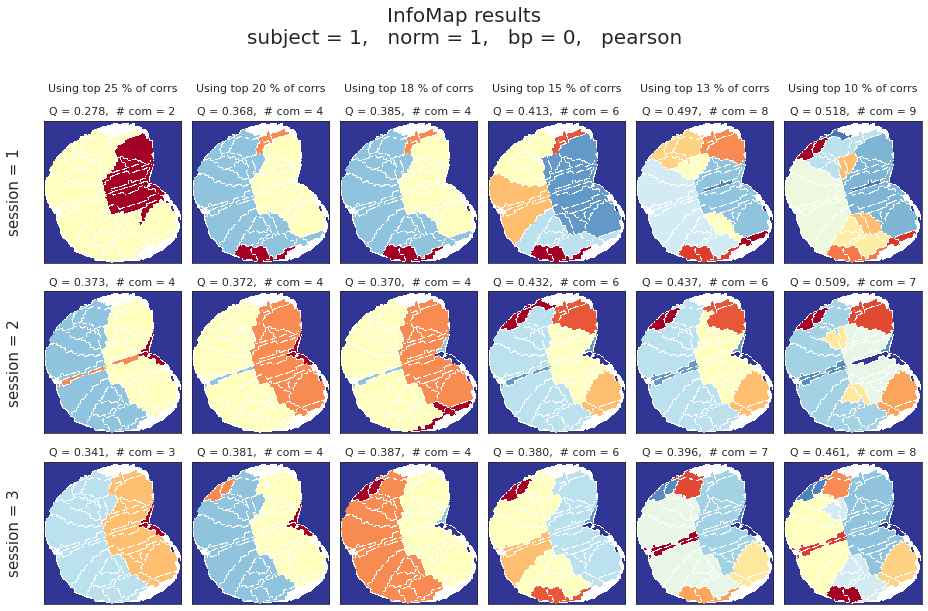

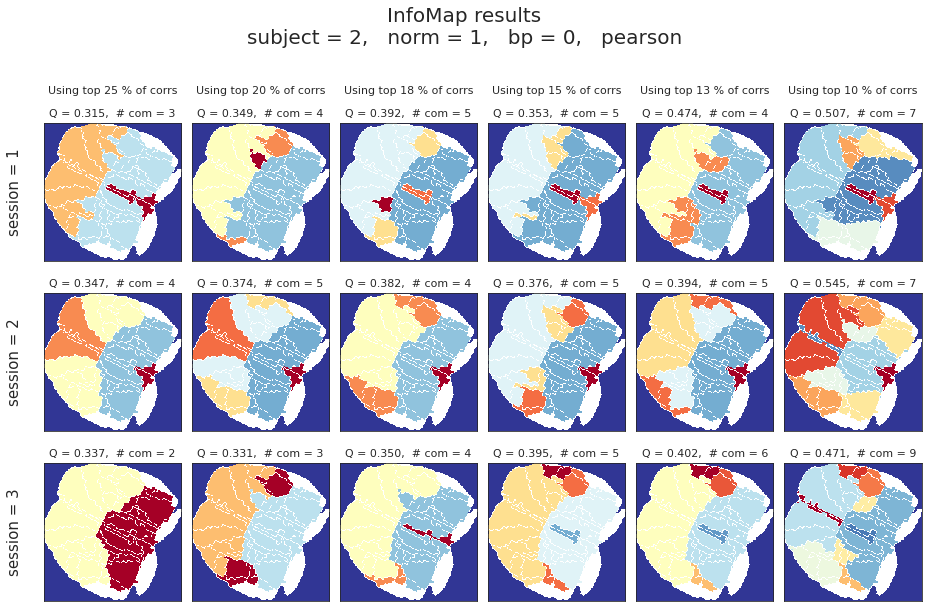

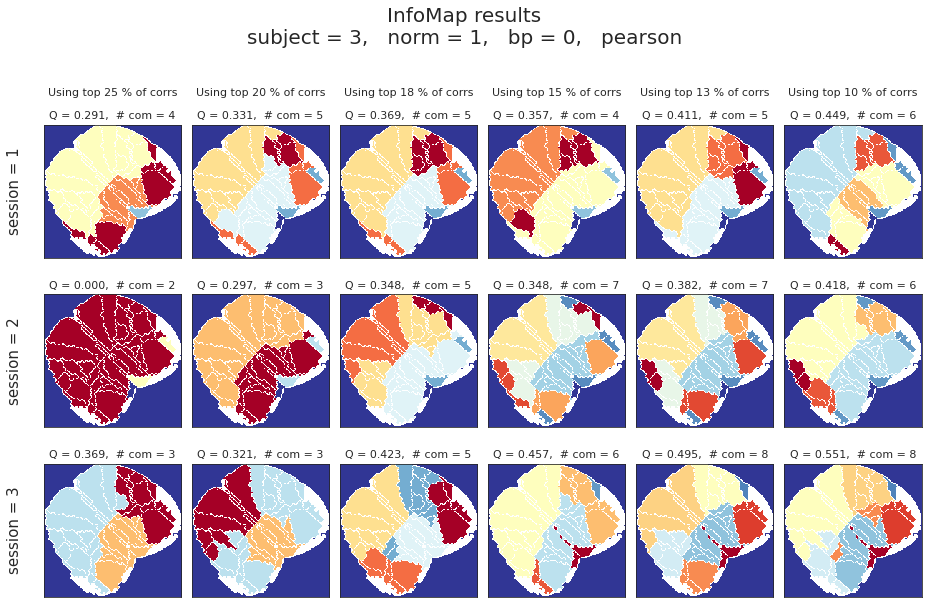

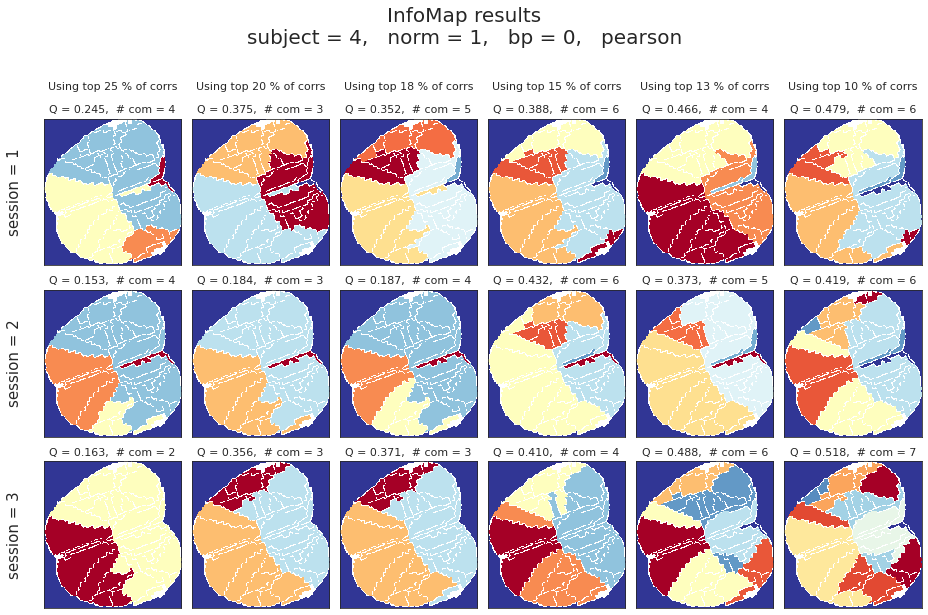

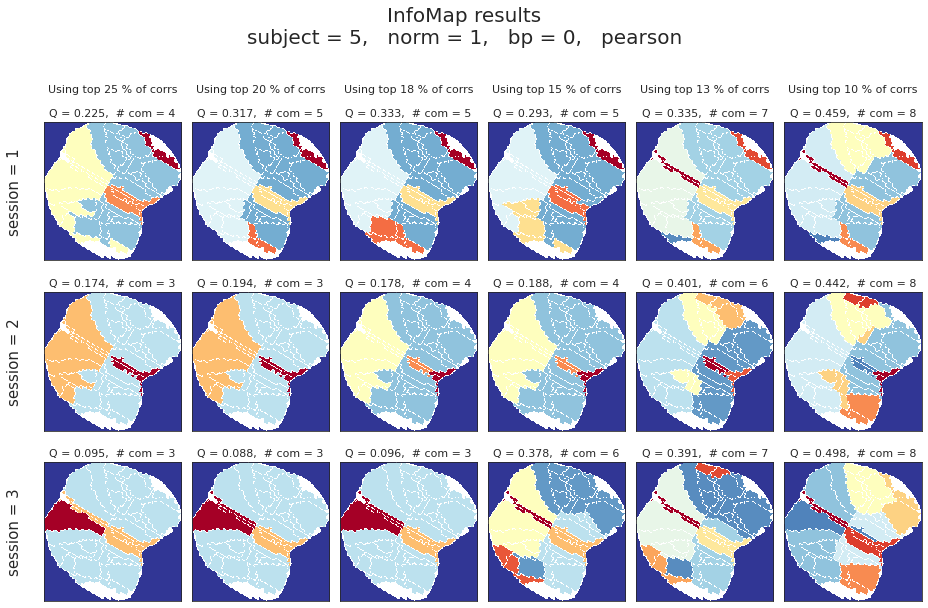

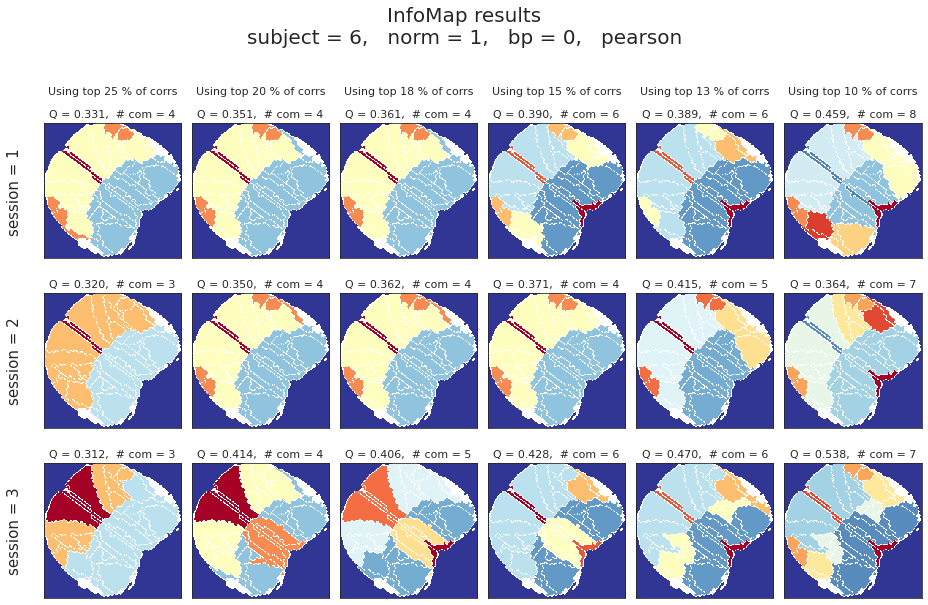

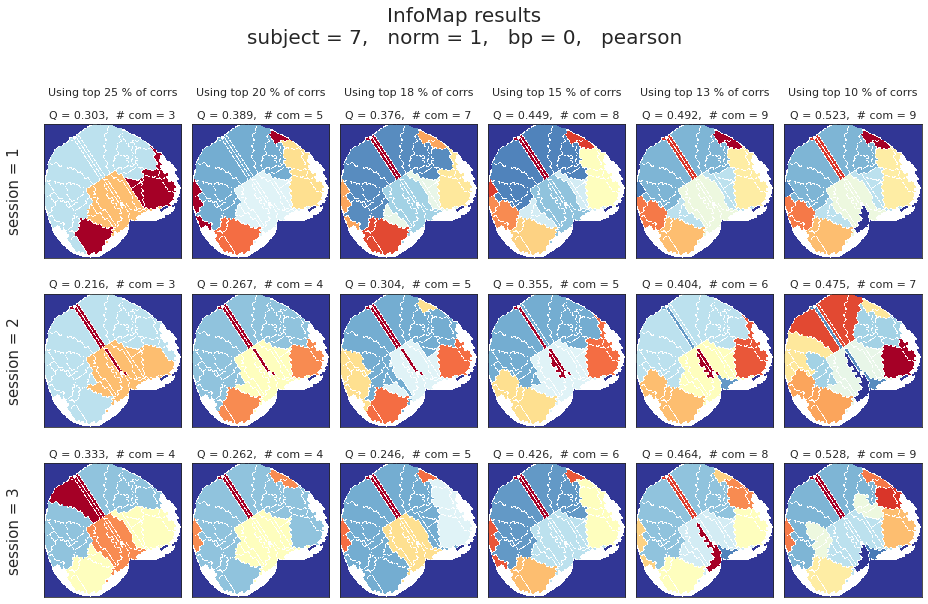

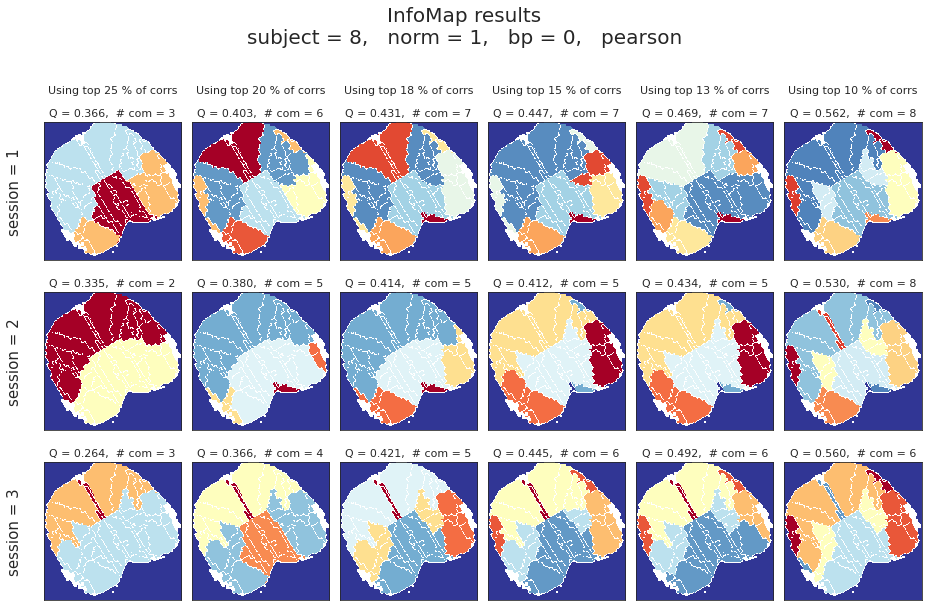

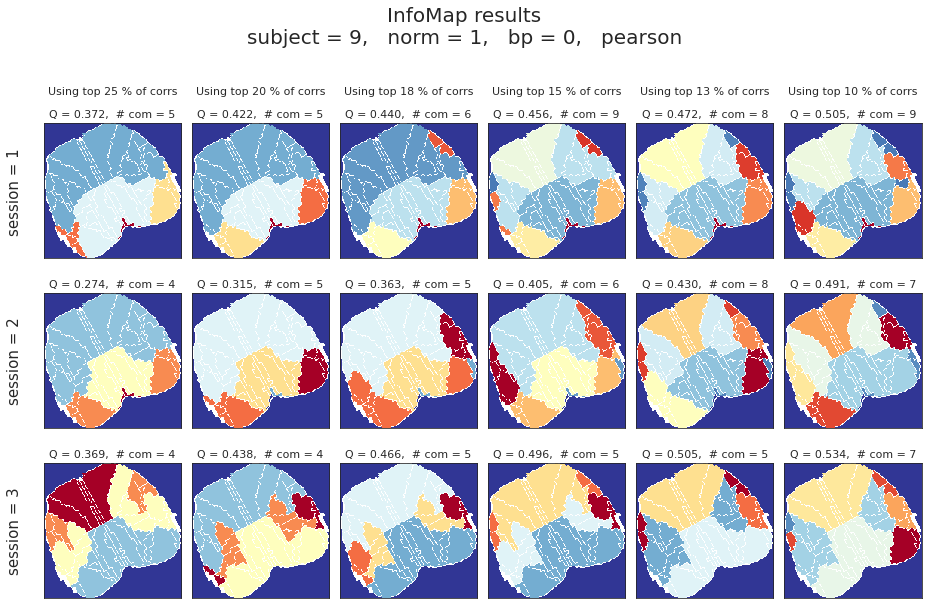

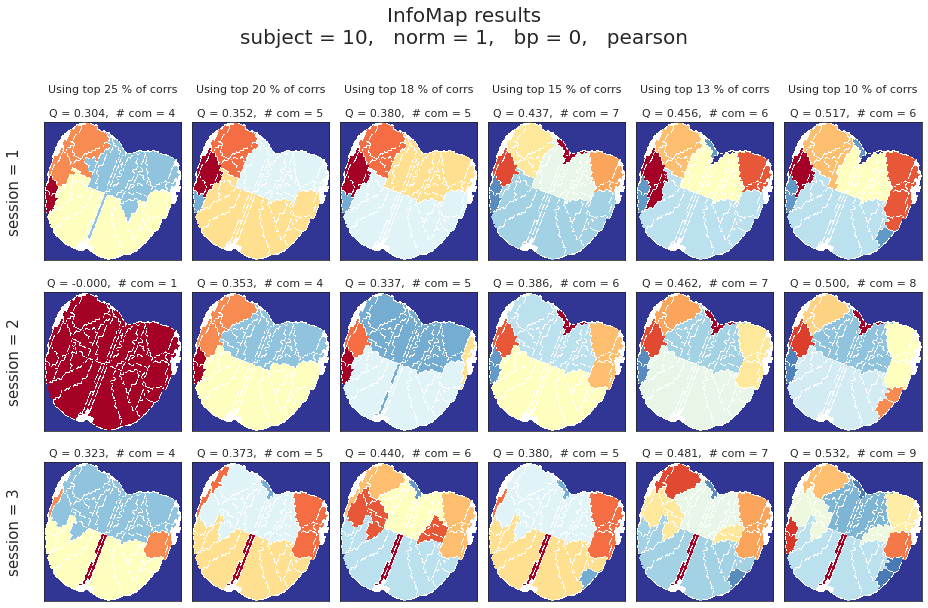

In [19]:
# HIDE CODE


mode = 'ca'
key_pre = 'mode-{:s}'.format(mode)
norm, bp = 1, 0
key_post = 'norm-{:s}_bp-{:s}'.format(str(norm), str(bp))

config = Config()

for subject in range(1, config.num_subjects+1):
    session = 2
    run = 1

    load = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    atls_org = organize_atlas(load, include=common_regions)
    excluded_regions = [k for k in atls_org['regions'] if k not in common_regions]
    cond = [atls_org['atlas'] == r for r in excluded_regions] + [atls_org['contour']]
    contour_refined = functools.reduce(np.logical_or, cond)

    sns.set_style('white')
    nrows, ncols = 3, len(percentiles)
    fig, axes = plt.subplots(nrows, ncols, figsize=(13, 8.5))
    axes = axes.reshape(nrows, ncols)

    for i, session in enumerate([1, 2, 3]):
        key = '{:s}_sub-SLC{:02d}_ses-{:d}_{:s}'
        key = key.format(key_pre, subject, session, key_post)
        for j, perc in enumerate(percentiles):
            tmp_key = '{:s}_perc-{:d}'.format(key, perc)
            try:
                data = graph_all[tmp_key]
            except KeyError:
                continue

            node_labels = data.node_labels
            g = data.g

            infomap_coms = cdlib_algorithms.infomap(g)
            infomap_community = infomap_coms.communities
            _nodes_in_communities = set.union(*(set(x) for x in infomap_community))
            infomap_partition = convert('community', 'partition', community=infomap_community)
            output = filter_islands(infomap_partition, atls_org['atlas'], node_labels, min_com_size=0)

            infomap_community.append([node for node in g.nodes if node not in _nodes_in_communities])
            q = nx_comm.modularity(g, communities=infomap_community)

            if i == 0:
                msg = 'Using top {:d} {:s} of corrs\n\n'.format(perc, '%')
            else:
                msg = ''
            msg += 'Q = {:.3f},  # com = {:d}'
            msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))

            data2plt = np.ma.masked_where(contour_refined, output['comm_mat'])
            im = axes[i, j].imshow(data2plt, cmap='RdYlBu_r', interpolation='none')
            axes[i, j].set_title(msg, fontsize=11)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if j == 0:
                axes[i, j].set_ylabel('session = {:d}\n'.format(session), fontsize=15)

    msg = 'InfoMap results\nsubject = {:d},   norm = {:s},   bp = {:s},   pearson'
    sup = fig.suptitle(msg.format(subject, str(norm), str(bp)), fontsize=20, y=1.02)
    fig.tight_layout()    
    plt.show()

    print('\n\n')

#### Leiden

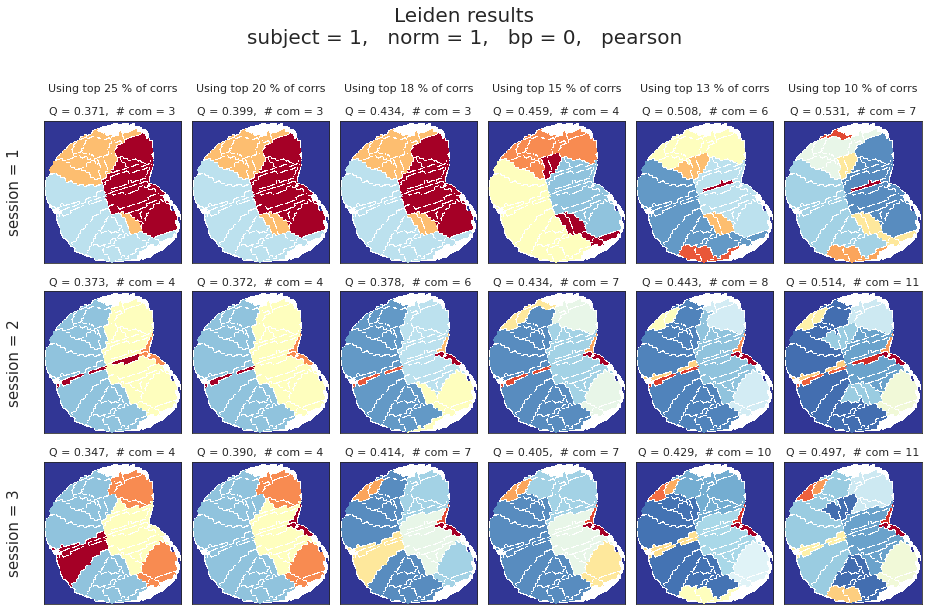

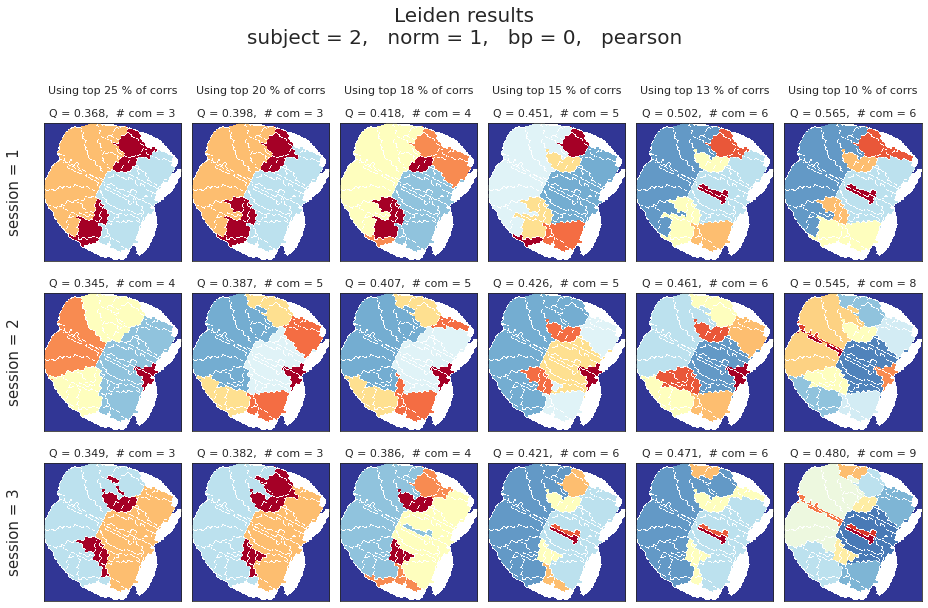

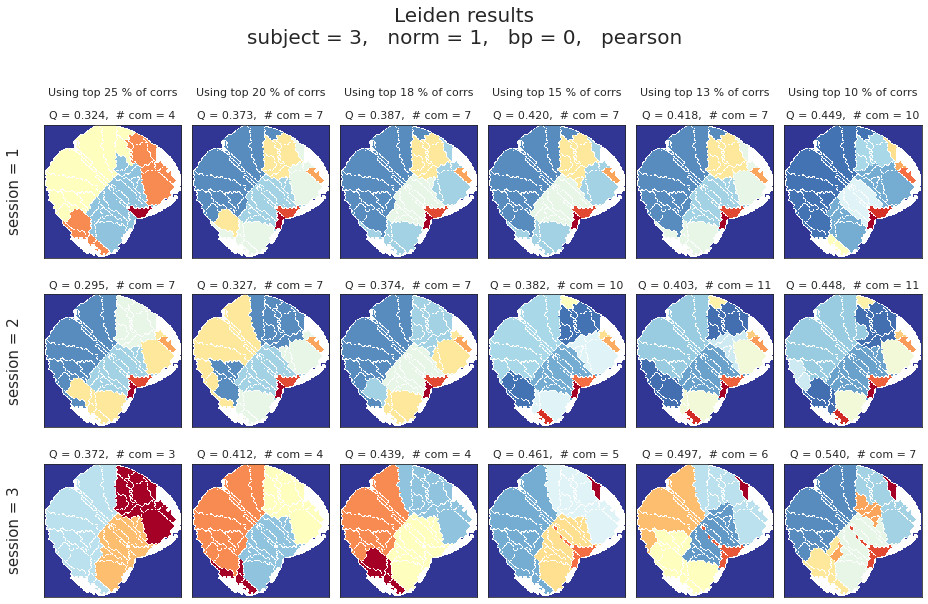

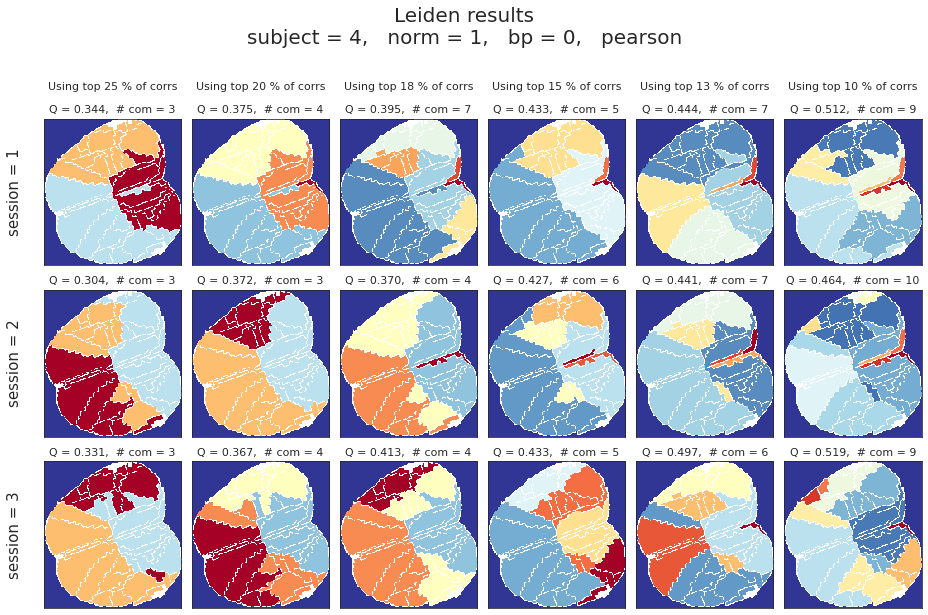

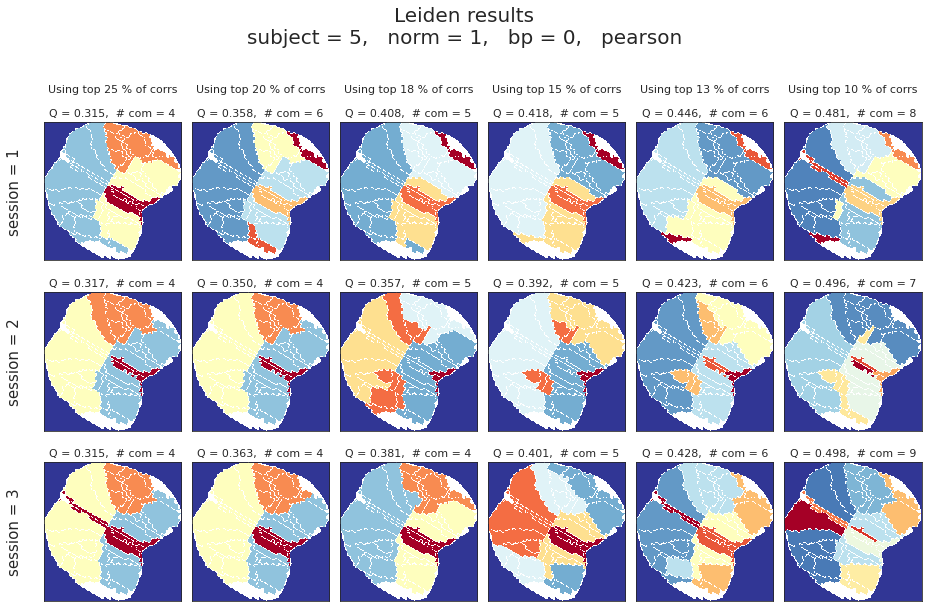

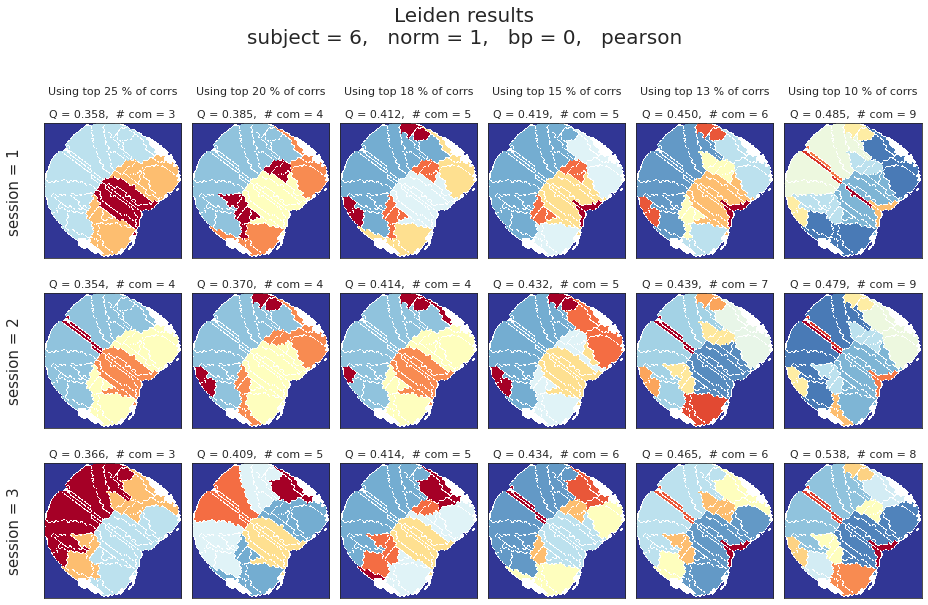

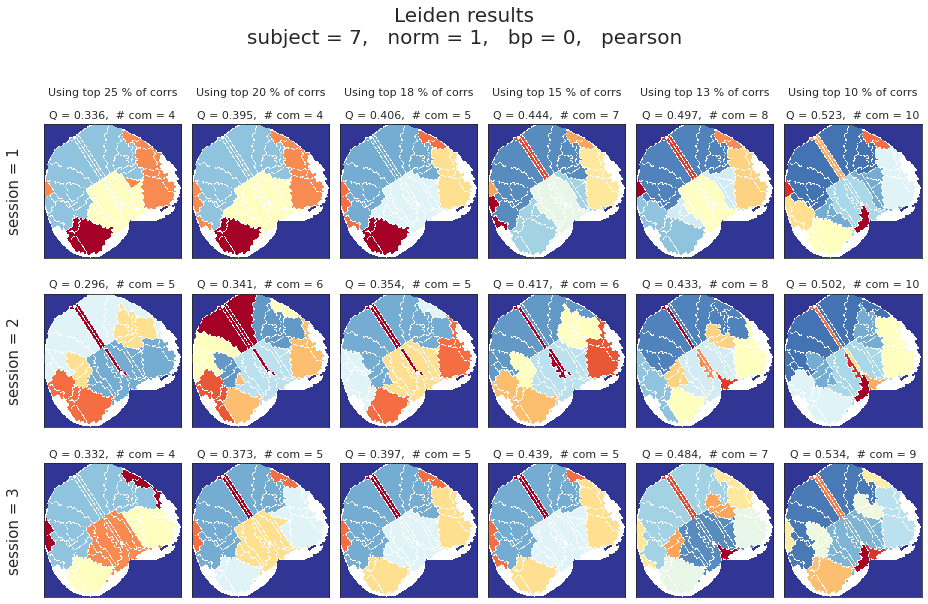

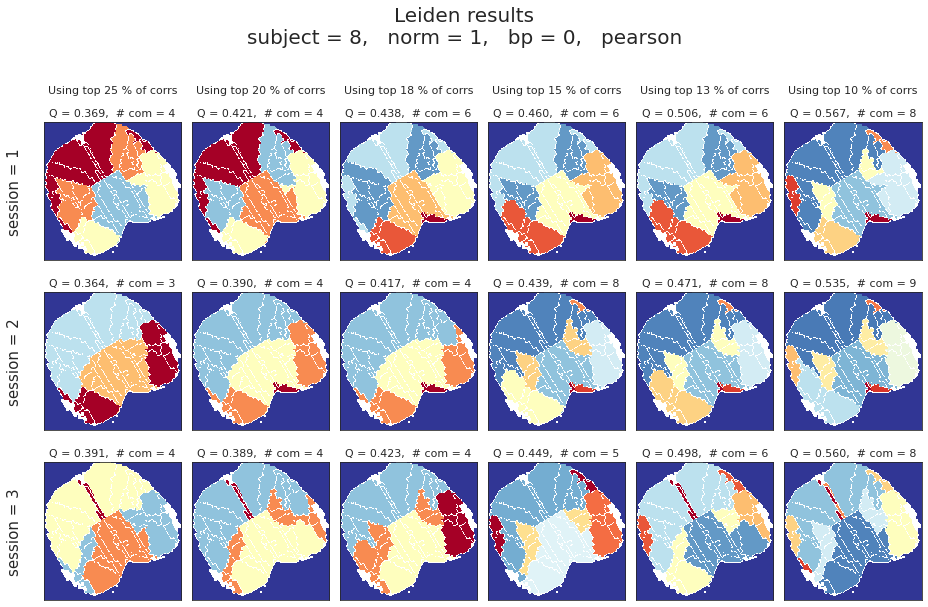

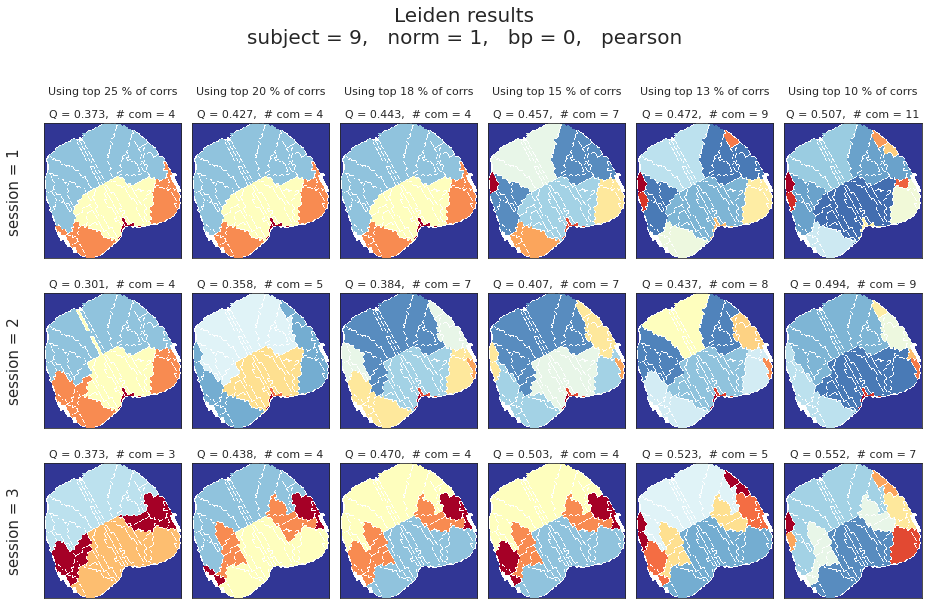

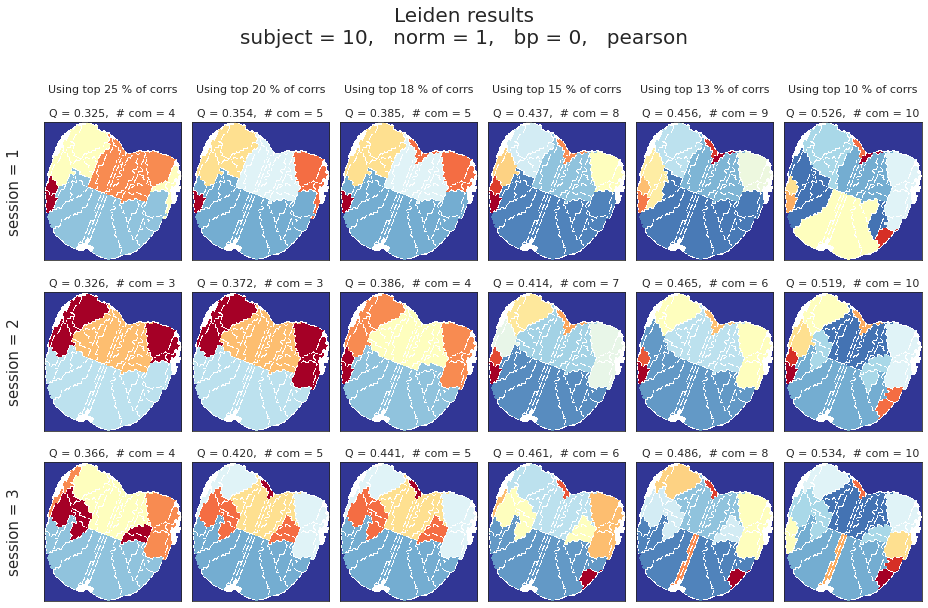

In [20]:
# HIDE CODE

mode = 'ca'
key_pre = 'mode-{:s}'.format(mode)
norm, bp = 1, 0
key_post = 'norm-{:s}_bp-{:s}'.format(str(norm), str(bp))

config = Config()

for subject in range(1, config.num_subjects+1):
    session = 2
    run = 1

    load = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    atls_org = organize_atlas(load, include=common_regions)
    excluded_regions = [k for k in atls_org['regions'] if k not in common_regions]
    cond = [atls_org['atlas'] == r for r in excluded_regions] + [atls_org['contour']]
    contour_refined = functools.reduce(np.logical_or, cond)

    sns.set_style('white')
    nrows, ncols = 3, len(percentiles)
    fig, axes = plt.subplots(nrows, ncols, figsize=(13, 8.5))
    axes = axes.reshape(nrows, ncols)

    for i, session in enumerate([1, 2, 3]):
        key = '{:s}_sub-SLC{:02d}_ses-{:d}_{:s}'
        key = key.format(key_pre, subject, session, key_post)
        for j, perc in enumerate(percentiles):
            tmp_key = '{:s}_perc-{:d}'.format(key, perc)
            try:
                data = graph_all[tmp_key]
            except KeyError:
                continue

            node_labels = data.node_labels
            g = data.g

            leiden_coms = cdlib_algorithms.leiden(g, weights='weight')
            leiden_community = leiden_coms.communities
            _nodes_in_communities = set.union(*(set(x) for x in leiden_community))
            leiden_partition = convert('community', 'partition', community=leiden_community)
            output = filter_islands(leiden_partition, atls_org['atlas'], node_labels, min_com_size=0)

            q = nx_comm.modularity(g, communities=leiden_community)

            if i == 0:
                msg = 'Using top {:d} {:s} of corrs\n\n'.format(perc, '%')
            else:
                msg = ''
            msg += 'Q = {:.3f},  # com = {:d}'
            msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))

            data2plt = np.ma.masked_where(contour_refined, output['comm_mat'])
            im = axes[i, j].imshow(data2plt, cmap='RdYlBu_r', interpolation='none')
            axes[i, j].set_title(msg, fontsize=11)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if j == 0:
                axes[i, j].set_ylabel('session = {:d}\n'.format(session), fontsize=15)

    msg = 'Leiden results\nsubject = {:d},   norm = {:s},   bp = {:s},   pearson'
    sup = fig.suptitle(msg.format(subject, str(norm), str(bp)), fontsize=20, y=1.02)
    fig.tight_layout()    
    plt.show()

    print('\n\n')

### Results: 10 x subjects

#### InfoMap

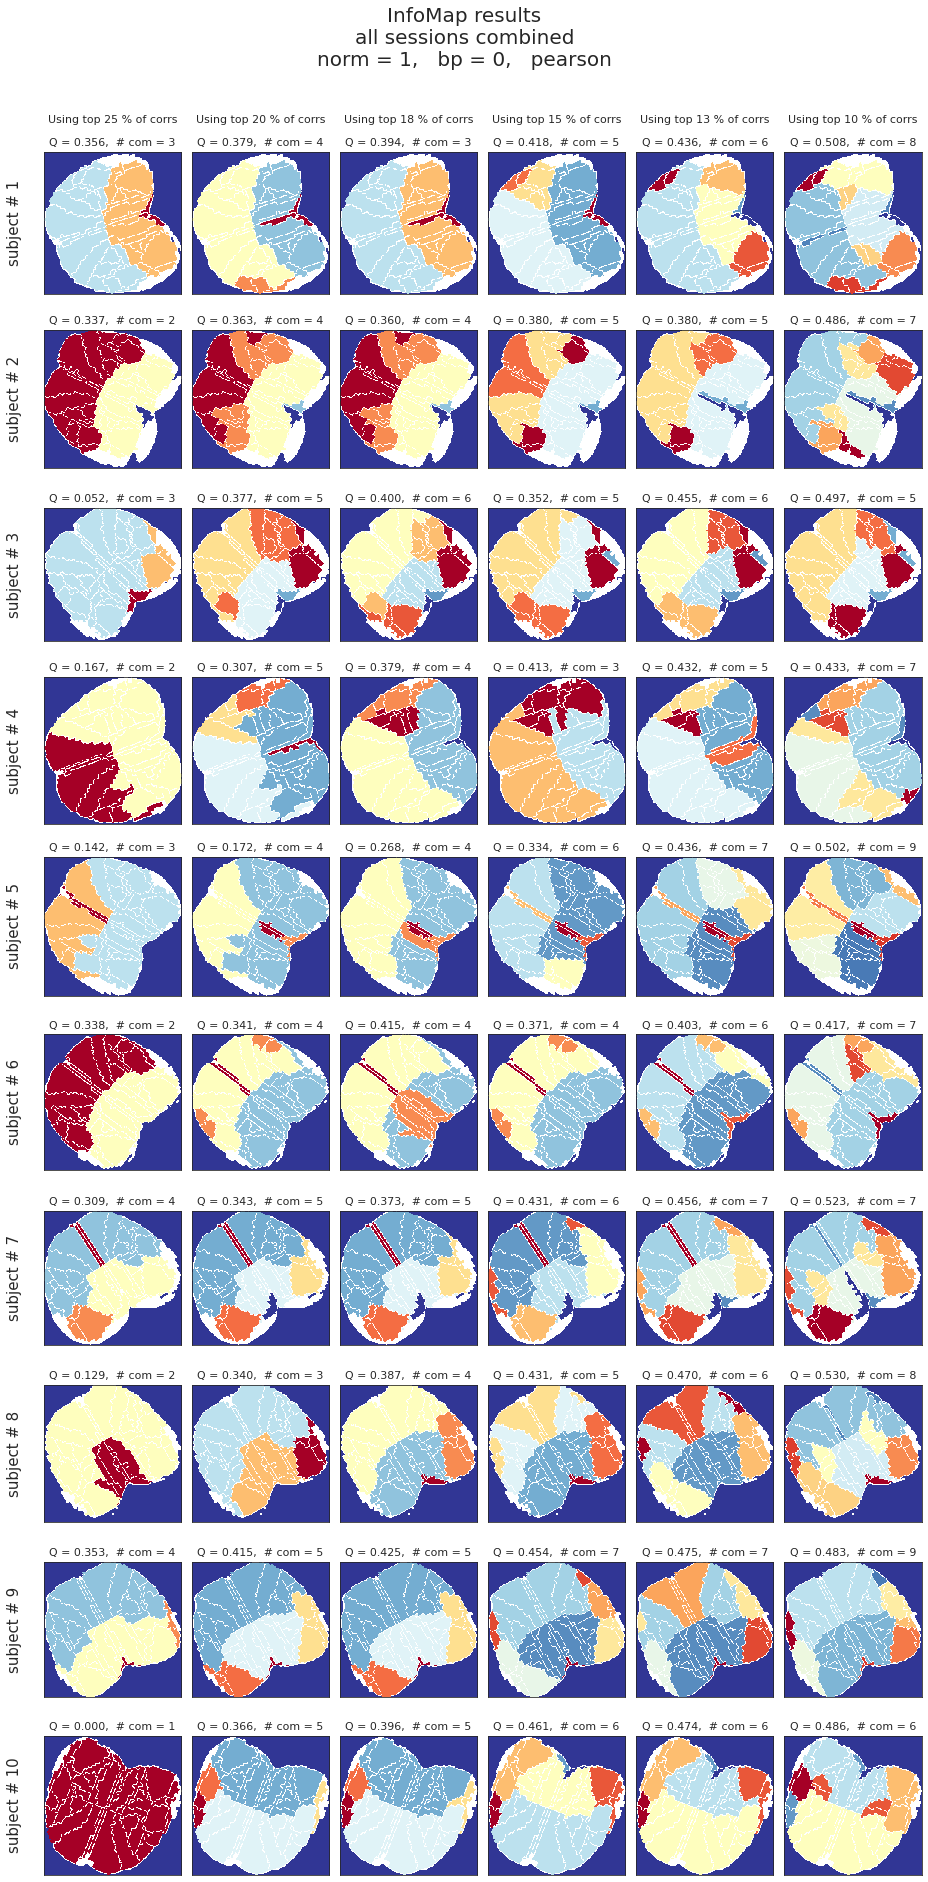

In [21]:
# HIDE CODE


mode = 'ca'
key_pre = 'mode-{:s}'.format(mode)
norm, bp = 1, 0
key_post = 'norm-{:s}_bp-{:s}'.format(str(norm), str(bp))

config = Config()

sns.set_style('white')
nrows, ncols = config.num_subjects, len(percentiles)
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 26))
axes = axes.reshape(nrows, ncols)

for i, subject in enumerate(range(1, config.num_subjects+1)):
    load = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        config=config,
        subject=subject,
        session=2,
        run=1,
    )
    atls_org = organize_atlas(load, include=common_regions)
    excluded_regions = [k for k in atls_org['regions'] if k not in common_regions]
    cond = [atls_org['atlas'] == r for r in excluded_regions] + [atls_org['contour']]
    contour_refined = functools.reduce(np.logical_or, cond)

    key = '{:s}_sub-SLC{:02d}_{:s}'
    key = key.format(key_pre, subject, key_post)
    for j, perc in enumerate(percentiles):
        tmp_key = '{:s}_perc-{:d}'.format(key, perc)
        try:
            data = graph_all[tmp_key]
        except KeyError:
            continue

        node_labels = data.node_labels
        g = data.g

        infomap_coms = cdlib_algorithms.infomap(g)
        infomap_community = infomap_coms.communities
        _nodes_in_communities = set.union(*(set(x) for x in infomap_community))
        infomap_partition = convert('community', 'partition', community=infomap_community)
        output = filter_islands(infomap_partition, atls_org['atlas'], node_labels, min_com_size=0)

        infomap_community.append([node for node in g.nodes if node not in _nodes_in_communities])
        q = nx_comm.modularity(g, communities=infomap_community)

        if i == 0:
            msg = 'Using top {:d} {:s} of corrs\n\n'.format(perc, '%')
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))

        data2plt = np.ma.masked_where(contour_refined, output['comm_mat'])
        im = axes[i, j].imshow(data2plt, cmap='RdYlBu_r', interpolation='none')
        axes[i, j].set_title(msg, fontsize=11)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

        if j == 0:
            axes[i, j].set_ylabel('subject # {:d}\n'.format(subject), fontsize=15)

msg = 'InfoMap results\nall sessions combined\nnorm = {:s},   bp = {:s},   pearson'
sup = fig.suptitle(msg.format(str(norm), str(bp)), fontsize=20, y=1.01)
fig.tight_layout()    
plt.show()

#### Leiden

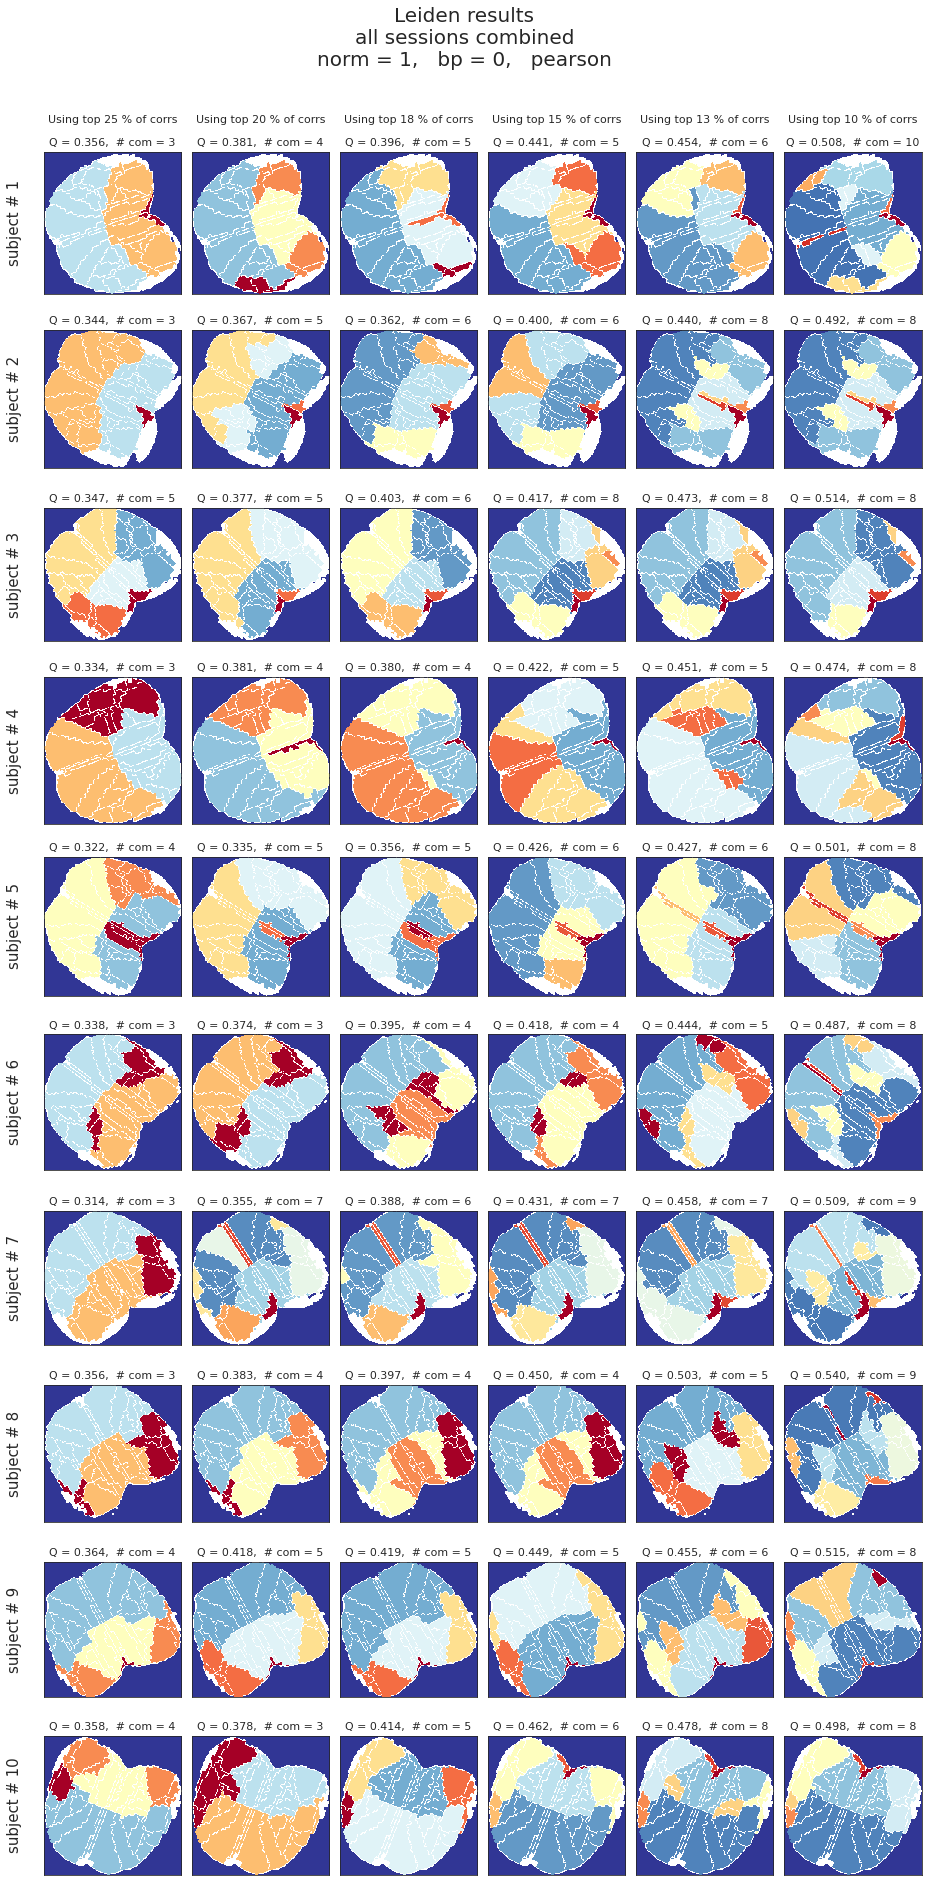

In [22]:
# HIDE CODE


mode = 'ca'
key_pre = 'mode-{:s}'.format(mode)
norm, bp = 1, 0
key_post = 'norm-{:s}_bp-{:s}'.format(str(norm), str(bp))

config = Config()

sns.set_style('white')
nrows, ncols = config.num_subjects, len(percentiles)
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 26))
axes = axes.reshape(nrows, ncols)

for i, subject in enumerate(range(1, config.num_subjects+1)):
    load = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        config=config,
        subject=subject,
        session=2,
        run=1,
    )
    atls_org = organize_atlas(load, include=common_regions)
    excluded_regions = [k for k in atls_org['regions'] if k not in common_regions]
    cond = [atls_org['atlas'] == r for r in excluded_regions] + [atls_org['contour']]
    contour_refined = functools.reduce(np.logical_or, cond)

    key = '{:s}_sub-SLC{:02d}_{:s}'
    key = key.format(key_pre, subject, key_post)
    for j, perc in enumerate(percentiles):
        tmp_key = '{:s}_perc-{:d}'.format(key, perc)
        try:
            data = graph_all[tmp_key]
        except KeyError:
            continue

        node_labels = data.node_labels
        g = data.g

        leiden_coms = cdlib_algorithms.leiden(g, weights='weight')
        leiden_community = leiden_coms.communities
        _nodes_in_communities = set.union(*(set(x) for x in leiden_community))
        leiden_partition = convert('community', 'partition', community=leiden_community)
        output = filter_islands(leiden_partition, atls_org['atlas'], node_labels, min_com_size=0)

        q = nx_comm.modularity(g, communities=leiden_community)

        if i == 0:
            msg = 'Using top {:d} {:s} of corrs\n\n'.format(perc, '%')
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))

        data2plt = np.ma.masked_where(contour_refined, output['comm_mat'])
        im = axes[i, j].imshow(data2plt, cmap='RdYlBu_r', interpolation='none')
        axes[i, j].set_title(msg, fontsize=11)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

        if j == 0:
            axes[i, j].set_ylabel('subject # {:d}\n'.format(subject), fontsize=15)

msg = 'Leiden results\nall sessions combined\nnorm = {:s},   bp = {:s},   pearson'
sup = fig.suptitle(msg.format(str(norm), str(bp)), fontsize=20, y=1.01)
fig.tight_layout()    
plt.show()

### Results: global

#### Leiden & Infomap (bp=0)

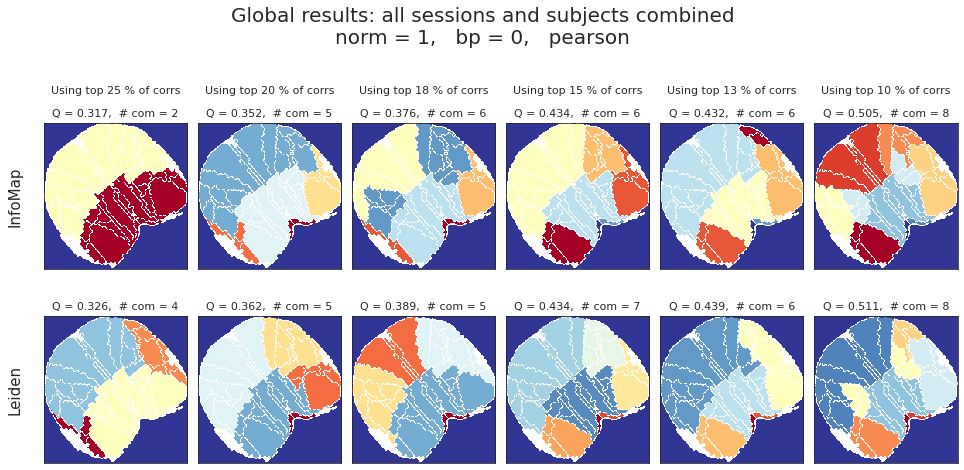

In [23]:
# HIDE CODE


mode = 'ca'
norm, bp = 1, 0
key_pre = 'mode-{:s}'.format(mode)
key_post = 'norm-{:s}_bp-{:s}'.format(str(norm), str(bp))
key = '{:s}_{:s}'.format(key_pre, key_post)

config = Config()

sns.set_style('white')
nrows, ncols = 2, len(percentiles)
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 7))
axes = axes.reshape(nrows, ncols)

load = load_organized_data(
    folder='atlas-allen_unfiltered_unnormalized',
    config=config,
    subject=6,
    session=1,
    run=1,
)
atls_org = organize_atlas(load, include=common_regions)
excluded_regions = [k for k in atls_org['regions'] if k not in common_regions]
cond = [atls_org['atlas'] == r for r in excluded_regions] + [atls_org['contour']]
contour_refined = functools.reduce(np.logical_or, cond)

for j, perc in enumerate(percentiles):
    tmp_key = '{:s}_perc-{:d}'.format(key, perc)
    try:
        data = graph_all[tmp_key]
    except KeyError:
        continue

    node_labels = data.node_labels
    g = data.g

    for i in range(2):
        if i == 0:
            infomap_coms = cdlib_algorithms.infomap(g)
            infomap_community = infomap_coms.communities
            _nodes_in_communities = set.union(*(set(x) for x in infomap_community))
            infomap_partition = convert('community', 'partition', community=infomap_community)
            output = filter_islands(infomap_partition, atls_org['atlas'], node_labels, min_com_size=0)

            infomap_community.append([node for node in g.nodes if node not in _nodes_in_communities])
            q = nx_comm.modularity(g, communities=infomap_community)
        else:
            leiden_coms = cdlib_algorithms.leiden(g, weights='weight')
            leiden_community = leiden_coms.communities
            _nodes_in_communities = set.union(*(set(x) for x in leiden_community))
            leiden_partition = convert('community', 'partition', community=leiden_community)
            output = filter_islands(leiden_partition, atls_org['atlas'], node_labels, min_com_size=0)

            q = nx_comm.modularity(g, communities=leiden_community)

        if i == 0:
            msg = 'Using top {:d} {:s} of corrs\n\n'.format(perc, '%')
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))

        data2plt = np.ma.masked_where(contour_refined, output['comm_mat'])
        im = axes[i, j].imshow(data2plt, cmap='RdYlBu_r', interpolation='none')
        axes[i, j].set_title(msg, fontsize=11)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

        if j == 0:
            axes[0, j].set_ylabel('InfoMap\n', fontsize=15)
            axes[1, j].set_ylabel('Leiden\n', fontsize=15)

msg = 'Global results: all sessions and subjects combined\nnorm = {:s},   bp = {:s},   pearson'
sup = fig.suptitle(msg.format(str(norm), str(bp)), fontsize=20, y=1.01)
fig.tight_layout()    
plt.show()

#### Leiden & Infomap (bp=1)

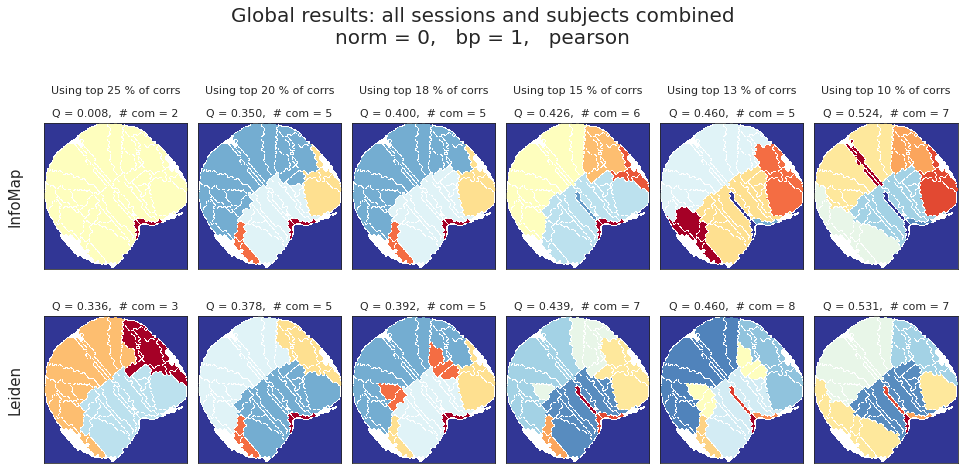

In [24]:
# HIDE CODE


mode = 'ca'
norm, bp = 0, 1
key_pre = 'mode-{:s}'.format(mode)
key_post = 'norm-{:s}_bp-{:s}'.format(str(norm), str(bp))
key = '{:s}_{:s}'.format(key_pre, key_post)

config = Config()

sns.set_style('white')
nrows, ncols = 2, len(percentiles)
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 7))
axes = axes.reshape(nrows, ncols)

load = load_organized_data(
    folder='atlas-allen_unfiltered_unnormalized',
    config=config,
    subject=6,
    session=1,
    run=1,
)
atls_org = organize_atlas(load, include=common_regions)
excluded_regions = [k for k in atls_org['regions'] if k not in common_regions]
cond = [atls_org['atlas'] == r for r in excluded_regions] + [atls_org['contour']]
contour_refined = functools.reduce(np.logical_or, cond)

for j, perc in enumerate(percentiles):
    tmp_key = '{:s}_perc-{:d}'.format(key, perc)
    try:
        data = graph_all[tmp_key]
    except KeyError:
        continue

    node_labels = data.node_labels
    g = data.g

    for i in range(2):
        if i == 0:
            infomap_coms = cdlib_algorithms.infomap(g)
            infomap_community = infomap_coms.communities
            _nodes_in_communities = set.union(*(set(x) for x in infomap_community))
            infomap_partition = convert('community', 'partition', community=infomap_community)
            output = filter_islands(infomap_partition, atls_org['atlas'], node_labels, min_com_size=0)

            infomap_community.append([node for node in g.nodes if node not in _nodes_in_communities])
            q = nx_comm.modularity(g, communities=infomap_community)
        else:
            leiden_coms = cdlib_algorithms.leiden(g, weights='weight')
            leiden_community = leiden_coms.communities
            _nodes_in_communities = set.union(*(set(x) for x in leiden_community))
            leiden_partition = convert('community', 'partition', community=leiden_community)
            output = filter_islands(leiden_partition, atls_org['atlas'], node_labels, min_com_size=0)

            q = nx_comm.modularity(g, communities=leiden_community)

        if i == 0:
            msg = 'Using top {:d} {:s} of corrs\n\n'.format(perc, '%')
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))

        data2plt = np.ma.masked_where(contour_refined, output['comm_mat'])
        im = axes[i, j].imshow(data2plt, cmap='RdYlBu_r', interpolation='none')
        axes[i, j].set_title(msg, fontsize=11)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

        if j == 0:
            axes[0, j].set_ylabel('InfoMap\n', fontsize=15)
            axes[1, j].set_ylabel('Leiden\n', fontsize=15)

msg = 'Global results: all sessions and subjects combined\nnorm = {:s},   bp = {:s},   pearson'
sup = fig.suptitle(msg.format(str(norm), str(bp)), fontsize=20, y=1.01)
fig.tight_layout()    
plt.show()

## Network measures

In [25]:
# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length

In [26]:
from copy import deepcopy as dc

In [27]:
measures_df = pd.DataFrame()

dict_list = []
for k, data in tqdm(graph_all.items()):
    
    # shared data
    shared_data_dict = {
        'norm': [data.norm] * 6,
        'bp': [0 if data.bp_order is None else 1] * 6,
        'subject': [data.subject] * 6,
        'session': [data.session] * 6,
        'run': [data.run] * 6,
        'percentile': [data.percentile] * 6,
        'lbl': [
            'avg_clustering',
            'local_efficiency',
            'large_clique_ratio',
            'avg_shortest_path_len',
            'global_efficiency',
            'degree_corr_coef',
        ],
    }
    
    # the real graph
    real_avg_clustering = average_clustering(data.g, weight='weight')
    real_local_efficiency = local_efficiency(data.g)
    real_large_clique_ratio = large_clique_size(data.g) / len(common_regions)
    try:
        real_avg_shortest_path_len = average_shortest_path_length(data.g, weight='weight')
    except:
        real_avg_shortest_path_len = np.nan
    real_global_efficiency = global_efficiency(data.g)
    real_degree_corr_coef = degree_pearson_correlation_coefficient(data.g, weight='weight')
    
    # configuration model
    cfg_avg_clustering = average_clustering(data.cfg, weight='weight')
    cfg_local_efficiency = local_efficiency(data.cfg)
    cfg_large_clique_ratio = large_clique_size(data.cfg) / len(common_regions)
    try:
        cfg_avg_shortest_path_len = average_shortest_path_length(data.cfg, weight='weight')
    except:
        cfg_avg_shortest_path_len = np.nan
    cfg_global_efficiency = global_efficiency(data.cfg)
    cfg_degree_corr_coef = degree_pearson_correlation_coefficient(data.cfg, weight='weight')

    # add data
    data_dict = dc(shared_data_dict)
    data_dict.update({
        'tag': ['real'] * 6,
        'val': [
            real_avg_clustering,
            real_local_efficiency,
            real_large_clique_ratio,
            real_avg_shortest_path_len,
            real_global_efficiency,
            real_degree_corr_coef,
        ],
    })
    dict_list.append(data_dict)

    data_dict = dc(shared_data_dict)
    data_dict.update({
        'tag': ['cfg'] * 6,
        'val': [
            cfg_avg_clustering,
            cfg_local_efficiency,
            cfg_large_clique_ratio,
            cfg_avg_shortest_path_len,
            cfg_global_efficiency,
            cfg_degree_corr_coef,
        ],
    })
    dict_list.append(data_dict)

    data_dict = dc(shared_data_dict)
    data_dict.update({
        'tag': ['ratio'] * 6,
        'val': [
            real_avg_clustering / cfg_avg_clustering,
            real_local_efficiency / cfg_local_efficiency,
            real_large_clique_ratio / cfg_large_clique_ratio,
            real_avg_shortest_path_len / cfg_avg_shortest_path_len,
            real_global_efficiency / cfg_global_efficiency,
            real_degree_corr_coef / cfg_degree_corr_coef,
        ],
    })
    dict_list.append(data_dict)

measures_df = pd.DataFrame.from_dict(merge_dicts(dict_list))

  0%|          | 0/3744 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [28]:
measures_df.shape

(67392, 9)

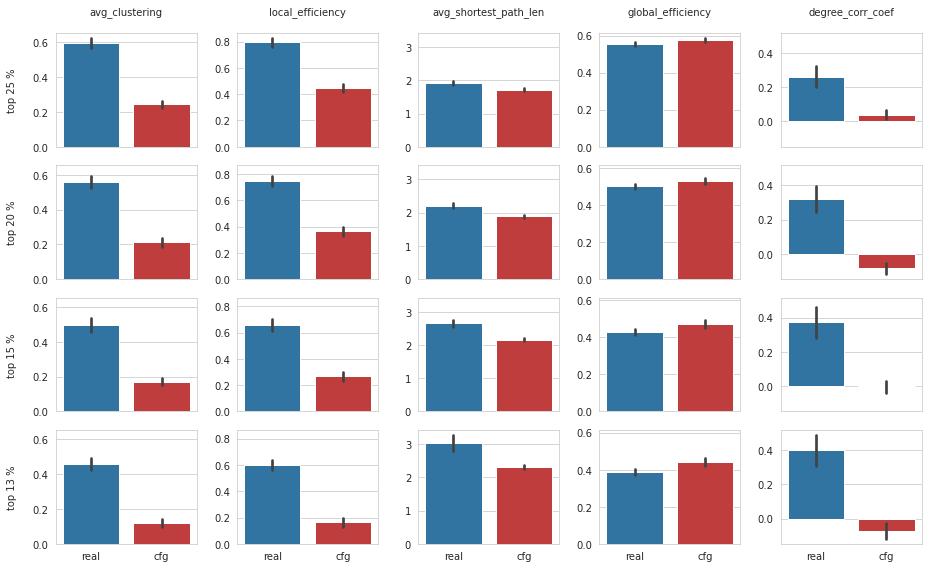

In [29]:
_perc = [25, 20, 15, 13]
_lbls = measures_df.lbl.unique().tolist()
_lbls = [item for item in _lbls if item != 'large_clique_ratio']
_tags = ['real', 'cfg']

norm = 1
bp = 0

sns.set_style('whitegrid')
nrows, ncols = len(_perc), len(_lbls)
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 2*nrows), sharey='col', sharex='all')

for i, perc in enumerate(_perc):
    for j, lbl in enumerate(_lbls):
        selected_df = measures_df.loc[
            (measures_df.tag.isin(_tags)) &
            (measures_df.percentile == perc) &
            (measures_df.lbl == lbl) &
            (measures_df.norm == norm) &
            (measures_df.bp == bp) &
            (measures_df.run == -1)
            # (measures_df.session == -1)
        ]
        sns.barplot(
            data=selected_df,
            y='val',
            x='tag',
            hue='tag',
            ci='sd',
            order=_tags,
            hue_order=_tags,
            palette=['C0', 'C3'],
            dodge=False,
            ax=axes[i, j],
        )
        axes[i, j].legend().set_visible(False)
        axes[i, j].set_xlabel('')
        
        if i == 0:
            axes[i, j].set_title('{:s}\n'.format(lbl), fontsize=10)
            
        if j == 0:
            axes[i, j].set_ylabel('top {:d} {:s}\n'.format(perc, '%'), fontsize=10)
        else:
            axes[i, j].set_ylabel('')
            
        axes[i, j].tick_params(axis='x', rotation=0)

fig.tight_layout()
# fig.savefig('net_measures.pdf', dpi=300)
plt.show()

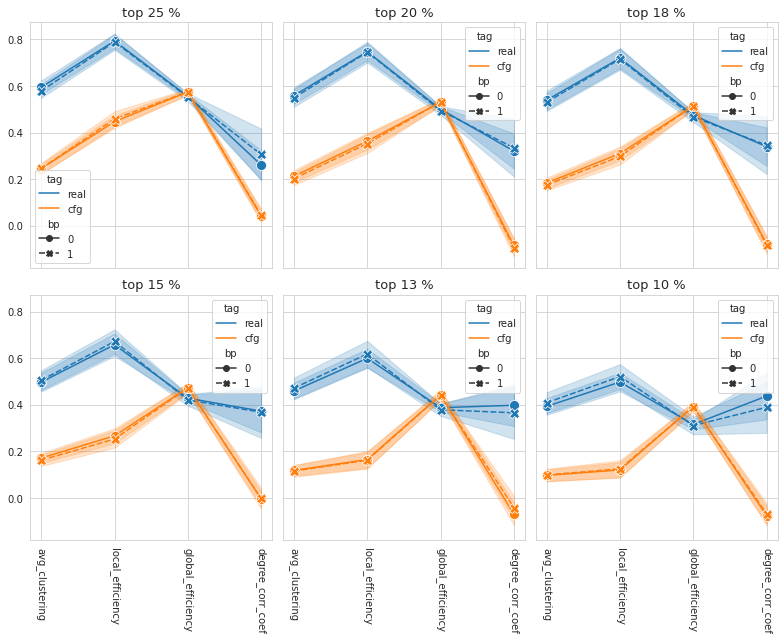

In [30]:
_perc = measures_df.percentile.unique().tolist()
_lbls = measures_df.lbl.unique().tolist()
_lbls = [item for item in _lbls if item not in ['large_clique_ratio', 'avg_shortest_path_len']]
_tags = ['real', 'cfg']

norm = 1

sns.set_style('whitegrid')
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(11, 9), sharey='all', sharex='all')

for idx, perc in enumerate(_perc):
    i, j = idx//ncols, idx%ncols
    selected_df = measures_df.loc[
        (measures_df.tag.isin(_tags)) &
        (measures_df.lbl.isin(_lbls)) &
        (measures_df.norm == norm) &
        (measures_df.run == -1) &
        (measures_df.percentile == perc)
    ]

    sns.lineplot(
        data=selected_df,
        x='lbl',
        y='val',
        hue='tag',
        style='bp',
        ci='sd',
        markers=True,
        markersize=10,
        ax=axes[i, j],
    )
    # axes[i, j].legend().set_visible(False)
    axes[i, j].set_xlabel('')
    axes[i, j].set_ylabel('')
    axes[i, j].tick_params(axis='x', rotation=-90)

    axes[i, j].set_title('top {:d} {:s}'.format(perc, '%'), fontsize=13)
    
fig.tight_layout()
fig.savefig('net_measures.pdf', dpi=300)
plt.show()

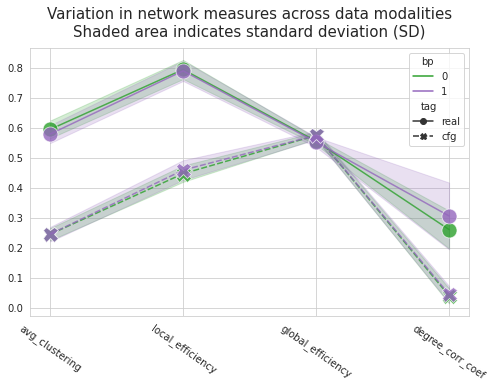

In [51]:
# _perc = measures_df.percentile.unique().tolist()
_perc = [25]
_lbls = measures_df.lbl.unique().tolist()
_lbls = [item for item in _lbls if item not in ['large_clique_ratio', 'avg_shortest_path_len']]
_tags = ['real', 'cfg']

norm = 1

sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(7, 5.5))

selected_df = measures_df.loc[
    (measures_df.tag.isin(_tags)) &
    (measures_df.lbl.isin(_lbls)) &
    (measures_df.percentile.isin(_perc)) &
    (measures_df.norm == norm) &
    (measures_df.run == -1)
]

line = sns.lineplot(
    data=selected_df,
    x='lbl',
    y='val',
    hue='bp',
    palette=['C2', 'C4'],
    style='tag',
    ci='sd',
    markers=True,
    markersize=15,
    alpha=0.8,
    ax=ax,
)
# leg = line.get_legend()
# plt.setp(leg.get_texts()[0], text='Mode', fontsize=8)
# plt.setp(leg.get_texts()[1], text='$Ca^{2+}$', fontsize=10)
# plt.setp(leg.get_texts()[2], text='$BOLD$', fontsize=9)
# plt.setp(leg.get_texts()[3], text='Graph', fontsize=8)

ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='x', rotation=-35, labelsize=10)
msg = 'Variation in network measures across data modalities\n'
msg += 'Shaded area indicates standard deviation (SD)'
ax.set_title(msg, y=1.02, fontsize=15)

fig.tight_layout()
fig.savefig('net_measures_lineplot.pdf', dpi=300, bbox_inches='tight')
plt.show()

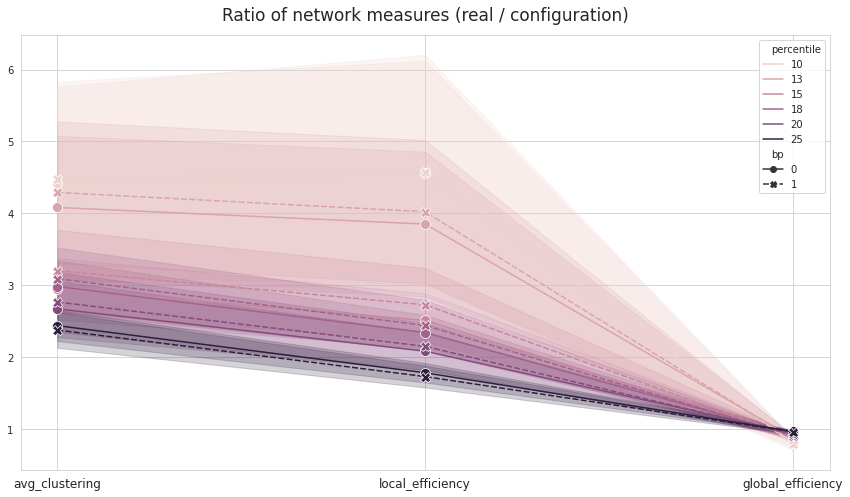

In [53]:
_perc = measures_df.percentile.unique().tolist()
_lbls = measures_df.lbl.unique().tolist()
_lbls = [
    item for item in _lbls if item not in
    ['large_clique_ratio', 'degree_corr_coef', 'avg_shortest_path_len']
]

norm = 1

sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

selected_df = measures_df.loc[
    (measures_df.lbl.isin(_lbls)) &
    (measures_df.tag == 'ratio') &
    (measures_df.norm == norm) &
    (measures_df.run == -1)
]

sns.lineplot(
    data=selected_df,
    x='lbl',
    y='val',
    hue='percentile',
    style='bp',
    ci='sd',
    markers=True,
    markersize=10,
    ax=ax,
)
# axes[i, j].legend().set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='x', labelsize=12)

ax.set_title('Ratio of network measures (real / configuration)', fontsize=17, y=1.02)
fig.tight_layout()
fig.savefig('net_measures_vs_cutoff.pdf', dpi=300, bbox_inches='tight')
plt.show()
# if i == 0:
 #    axes[i, j].set_title('top {:d} {:s}\n'.format(perc, '%'), fontsize=10)

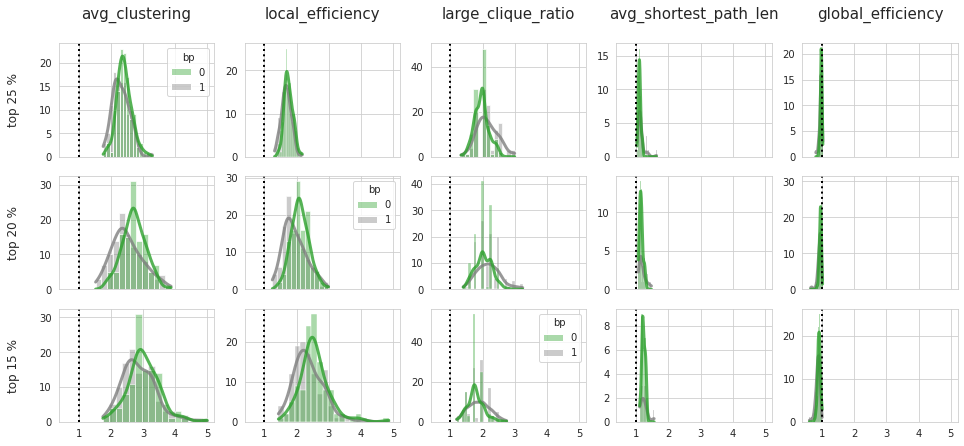

In [55]:
# _perc = measures_df.percentile.unique().tolist()
# _perc = [item for item in _perc if item % 5 == 0]
_perc = [25, 20, 15]

_lbls = measures_df.lbl.unique().tolist()
_lbls = [item for item in _lbls if item not in ['degree_corr_coef']]
# _lbls = [item for item in _lbls if item not in ['avg_shortest_path_len', 'degree_corr_coef']]
# _lbls = [item for item in _lbls if item != 'large_clique_ratio']

norm = 1
bp = 0

sns.set_style('whitegrid')
nrows, ncols = len(_perc), len(_lbls)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13.5, 2.1*nrows), sharex='all')

for i, perc in enumerate(_perc):
    for j, lbl in enumerate(_lbls):
        selected_df = measures_df.loc[
            (measures_df.tag == 'ratio') &
            (measures_df.percentile == perc) &
            (measures_df.lbl == lbl) &
            (measures_df.norm == norm) &
            # (measures_df.bp == bp) &
            (measures_df.subject != -1) &
            (measures_df.session != -1) &
            (measures_df.run != -1)
            # (measures_df.session == -1)
        ]
        sns.histplot(
            data=selected_df,
            x='val',
            hue='bp',
            hue_order=[0, 1],
            palette=['C2', 'C7'],
            legend=True if i == j else False,
            kde=True,
            alpha=0.4,
            line_kws={'lw': 3, 'alpha': 0.8},
            ax=axes[i, j],
        )
        axes[i, j].axvline(1, ls=':', lw=2, color='k')
        # axes[i, j].legend().set_visible(False)
        axes[i, j].set_xlabel('')
        
        if i == 0:
            axes[i, j].set_title('{:s}\n'.format(lbl), fontsize=15)
            
        if j == 0:
            axes[i, j].set_ylabel('top {:d} {:s}\n'.format(perc, '%'), fontsize=12)
        else:
            axes[i, j].set_ylabel('')
            
        axes[i, j].tick_params(axis='x', rotation=0)

fig.tight_layout()
fig.savefig('net_measures_ratio.pdf', dpi=300)
plt.show()

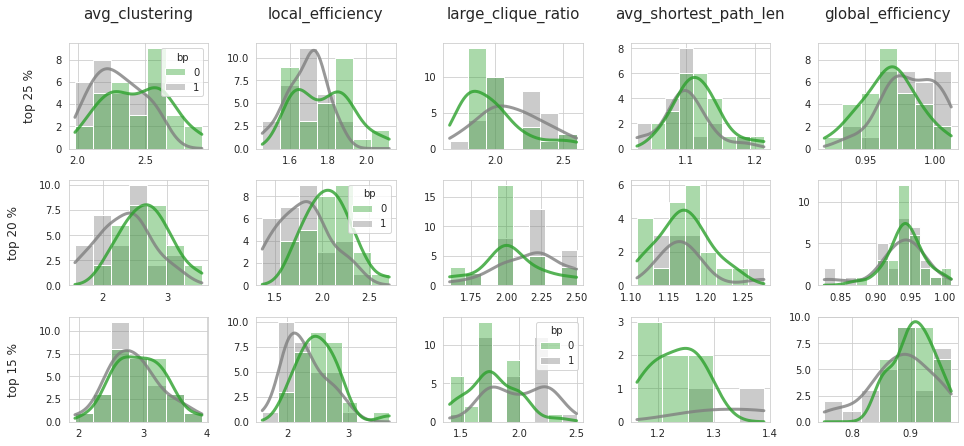

In [23]:
_perc = [25, 20, 15]
_lbls = measures_df.lbl.unique().tolist()
_lbls = [item for item in _lbls if item not in ['degree_corr_coef']]

norm = 1

sns.set_style('whitegrid')
nrows, ncols = len(_perc), len(_lbls)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13.5, 2.1*nrows))

for i, perc in enumerate(_perc):
    for j, lbl in enumerate(_lbls):
        selected_df = measures_df.loc[
            (measures_df.tag == 'ratio') &
            (measures_df.percentile == perc) &
            (measures_df.lbl == lbl) &
            (measures_df.norm == norm) &
            (measures_df.subject != -1) &
            (measures_df.session != -1) &
            (measures_df.run == -1)
        ]
        sns.histplot(
            data=selected_df,
            x='val',
            hue='bp',
            hue_order=[0, 1],
            palette=['C2', 'C7'],
            legend=True if i == j else False,
            kde=True,
            alpha=0.4,
            line_kws={'lw': 3, 'alpha': 0.8},
            ax=axes[i, j],
        )
        # axes[i, j].axvline(1, ls=':', lw=2, color='k')
        # axes[i, j].legend().set_visible(False)
        axes[i, j].set_xlabel('')
        
        if i == 0:
            axes[i, j].set_title('{:s}\n'.format(lbl), fontsize=15)
            
        if j == 0:
            axes[i, j].set_ylabel('top {:d} {:s}\n'.format(perc, '%'), fontsize=12)
        else:
            axes[i, j].set_ylabel('')
            
        axes[i, j].tick_params(axis='x', rotation=0)

fig.tight_layout()
fig.savefig('net_measures_ratio.pdf', dpi=300)
plt.show()

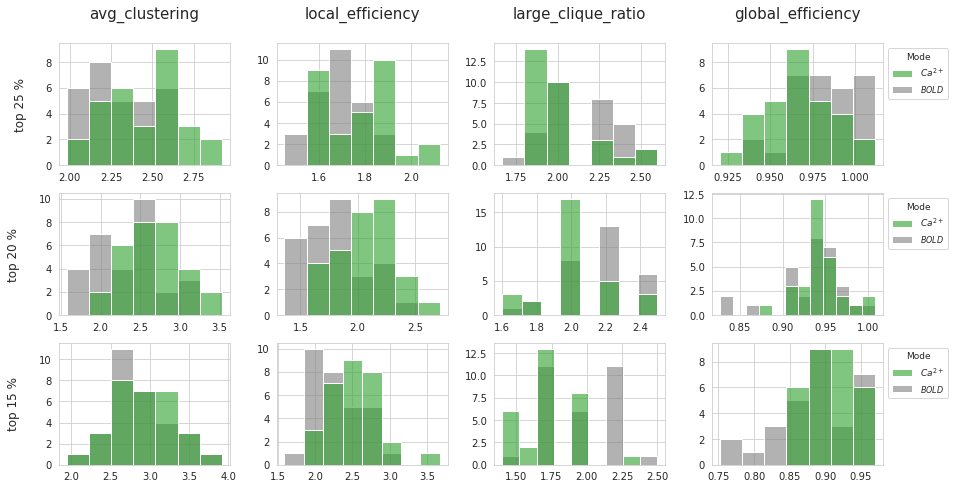

In [34]:
_perc = [25, 20, 15]
_lbls = measures_df.lbl.unique().tolist()
_lbls = [item for item in _lbls if item not in ['degree_corr_coef', 'avg_shortest_path_len']]

norm = 1

sns.set_style('whitegrid')
nrows, ncols = len(_perc), len(_lbls)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13.5, 2.3*nrows))

for i, perc in enumerate(_perc):
    for j, lbl in enumerate(_lbls):
        selected_df = measures_df.loc[
            (measures_df.tag == 'ratio') &
            (measures_df.percentile == perc) &
            (measures_df.lbl == lbl) &
            (measures_df.norm == norm) &
            (measures_df.subject != -1) &
            (measures_df.session != -1) &
            (measures_df.run == -1)
        ]
        hist = sns.histplot(
            data=selected_df,
            x='val',
            hue='bp',
            hue_order=[0, 1],
            palette=['C2', 'C7'],
            legend=True if j == 3 else False,
            alpha=0.6,
            ax=axes[i, j],
        )
        leg = hist.get_legend()
        
        if leg is not None:
            plt.setp(leg.get_texts()[0], text='$Ca^{2+}$', fontsize=9)
            plt.setp(leg.get_texts()[1], text='$BOLD$', fontsize=8)
            plt.setp(leg.get_title(), text='Mode', fontsize=9)
            plt.setp(leg, bbox_to_anchor=(1.0, 1.0)) 
        
        axes[i, j].set_xlabel('')
        
        if i == 0:
            axes[i, j].set_title('{:s}\n'.format(lbl), fontsize=15)
            
        if j == 0:
            axes[i, j].set_ylabel('top {:d} {:s}\n'.format(perc, '%'), fontsize=12)
        else:
            axes[i, j].set_ylabel('')
            
        axes[i, j].tick_params(axis='x', rotation=0)

fig.tight_layout()
fig.savefig('net_measures_ratio_hist.pdf', dpi=300)
plt.show()

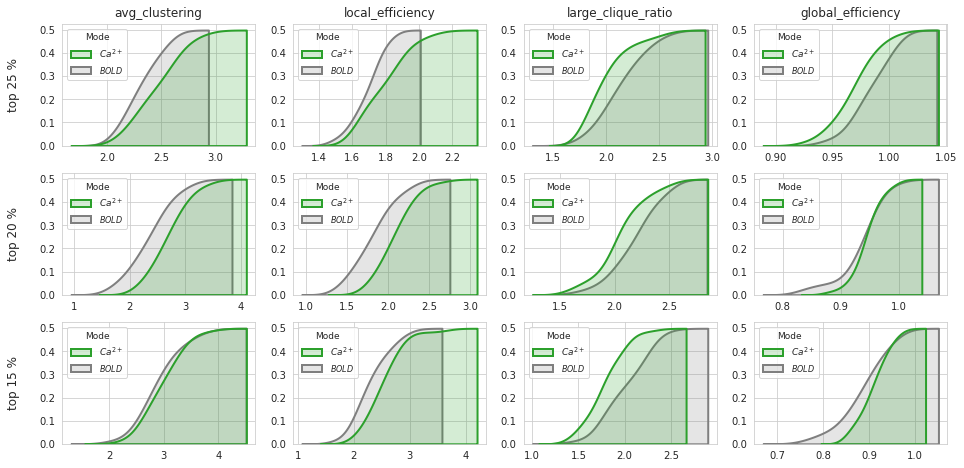

In [36]:
_perc = [25, 20, 15]
_lbls = measures_df.lbl.unique().tolist()
_lbls = [item for item in _lbls if item not in ['degree_corr_coef', 'avg_shortest_path_len']]

norm = 1

sns.set_style('whitegrid')
nrows, ncols = len(_perc), len(_lbls)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13.5, 2.2*nrows))

for i, perc in enumerate(_perc):
    for j, lbl in enumerate(_lbls):
        selected_df = measures_df.loc[
            (measures_df.tag == 'ratio') &
            (measures_df.percentile == perc) &
            (measures_df.lbl == lbl) &
            (measures_df.norm == norm) &
            (measures_df.subject != -1) &
            (measures_df.session != -1) &
            (measures_df.run == -1)
        ]
        kde = sns.kdeplot(
            data=selected_df,
            x='val',
            hue='bp',
            hue_order=[0, 1],
            palette=['C2', 'C7'],
            cumulative=True,
            fill=True,
            lw=2.,
            alpha=0.2,
            ax=axes[i, j],
        )
        leg = kde.get_legend()
        if leg is not None:
            plt.setp(leg.get_texts()[0], text='$Ca^{2+}$', fontsize=9)
            plt.setp(leg.get_texts()[1], text='$BOLD$', fontsize=8)
            plt.setp(leg.get_title(), text='Mode', fontsize=9)
            plt.setp(leg, bbox_to_anchor=(0.363, 1.0)) 

        if i == 0:
            axes[i, j].set_title('{:s}'.format(lbl), fontsize=12, y=1.01)
            
        if j == 0:
            axes[i, j].set_ylabel('top {:d} {:s}\n'.format(perc, '%'), fontsize=12)
        else:
            axes[i, j].set_ylabel('')
        
        axes[i, j].set_xlabel('')
        axes[i, j].tick_params(axis='x', rotation=0)

fig.tight_layout()
fig.savefig('net_measures_ratio_kde_cumu.pdf', dpi=300)
plt.show()

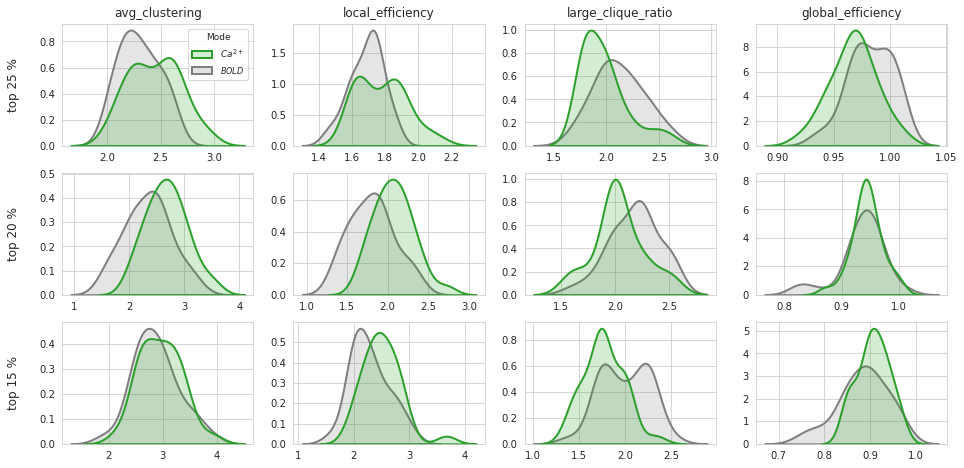

In [39]:
_perc = [25, 20, 15]
_lbls = measures_df.lbl.unique().tolist()
_lbls = [item for item in _lbls if item not in ['degree_corr_coef', 'avg_shortest_path_len']]

norm = 1

sns.set_style('whitegrid')
nrows, ncols = len(_perc), len(_lbls)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13.5, 2.2*nrows))

for i, perc in enumerate(_perc):
    for j, lbl in enumerate(_lbls):
        selected_df = measures_df.loc[
            (measures_df.tag == 'ratio') &
            (measures_df.percentile == perc) &
            (measures_df.lbl == lbl) &
            (measures_df.norm == norm) &
            (measures_df.subject != -1) &
            (measures_df.session != -1) &
            (measures_df.run == -1)
        ]
        kde = sns.kdeplot(
            data=selected_df,
            x='val',
            hue='bp',
            hue_order=[0, 1],
            palette=['C2', 'C7'],
            legend=True if i == j == 0 else False,
            cumulative=False,
            fill=True,
            lw=2.,
            alpha=0.2,
            ax=axes[i, j],
        )
        leg = kde.get_legend()
        if leg is not None:
            plt.setp(leg.get_texts()[0], text='$Ca^{2+}$', fontsize=9)
            plt.setp(leg.get_texts()[1], text='$BOLD$', fontsize=8)
            plt.setp(leg.get_title(), text='Mode', fontsize=9)

        if i == 0:
            axes[i, j].set_title('{:s}'.format(lbl), fontsize=12, y=1.01)
            
        if j == 0:
            axes[i, j].set_ylabel('top {:d} {:s}\n'.format(perc, '%'), fontsize=12)
        else:
            axes[i, j].set_ylabel('')
        
        axes[i, j].set_xlabel('')
        axes[i, j].tick_params(axis='x', rotation=0)

fig.tight_layout()
fig.savefig('net_measures_ratio_kde.pdf', dpi=300)
plt.show()

## Node centralities

### Global graphs

In [56]:
centralities = {}
centralities_cfg = {}

filter_keywords = ['sub', 'ses', 'run']
for key, data in tqdm(graph_all.items()):
    if any(x in key for x in filter_keywords):
        continue
    # real
    degree = nx.degree_centrality(data.g)
    closeness = nx.closeness_centrality(data.g, distance='weight')
    harmonic = nx.harmonic_centrality(data.g, distance='weight')
    betweenness = nx.betweenness_centrality(data.g, weight='weight')
    try:
        information = nx.information_centrality(data.g, weight='weight')
    except:
        information = {}
    eigenvector = nx.eigenvector_centrality(data.g, weight='weight')
    katz = nx.katz_centrality_numpy(data.g, weight='weight')
    centralities[key] = {
        'degree': {k: v/max(list(degree.values())) for k, v in degree.items()},
        'closeness': {k: v/max(list(closeness.values())) for k, v in closeness.items()},
        # 'harmonic': {k: v/max(list(harmonic.values())) for k, v in harmonic.items()},
        'betweenness': {k: v/max(list(betweenness.values())) for k, v in betweenness.items()},
        # 'information': information,
        'eigenvector': {k: v/max(list(eigenvector.values())) for k, v in eigenvector.items()},
        # 'katz': katz,
    }

    # cfg
    degree = nx.degree_centrality(data.cfg)
    closeness = nx.closeness_centrality(data.cfg, distance='weight')
    harmonic = nx.harmonic_centrality(data.cfg, distance='weight')
    betweenness = nx.betweenness_centrality(data.cfg, weight='weight')
    try:
        information = nx.information_centrality(data.cfg, weight='weight')
    except:
        information = {}
    eigenvector = nx.eigenvector_centrality(data.cfg, weight='weight')
    katz = nx.katz_centrality_numpy(data.cfg, weight='weight')
    centralities_cfg[key] = {
        'degree': {k: v/max(list(degree.values())) for k, v in degree.items()},
        'closeness': {k: v/max(list(closeness.values())) for k, v in closeness.items()},
        # 'harmonic': {k: v/max(list(harmonic.values())) for k, v in harmonic.items()},
        'betweenness': {k: v/max(list(betweenness.values())) for k, v in betweenness.items()},
        # 'information': information,
        'eigenvector': {k: v/max(list(eigenvector.values())) for k, v in eigenvector.items()},
        # 'katz': katz,
    }

  0%|          | 0/3744 [00:00<?, ?it/s]

In [57]:
norm = 1
bp = 0
perc = 15
key = 'mode-ca_norm-{:s}_bp-{:s}_perc-{:d}'
key = key.format(str(norm), str(bp), perc)

centralities_cortex = {}
for lbl, centrality_d in centralities[key].items():
    x = np.ones(load['atlas'].shape, dtype=float) * np.nan
    for node, value in centrality_d.items():
        region_id = node_labels[node]
        x[load['atlas'] == region_id] = value
    centralities_cortex[lbl] = x
    
centralities_cortex_cfg = {}
for lbl, centrality_d in centralities_cfg[key].items():
    x = np.ones(load['atlas'].shape, dtype=float) * np.nan
    for node, value in centrality_d.items():
        region_id = node_labels[node]
        x[load['atlas'] == region_id] = value
    centralities_cortex_cfg[lbl] = x

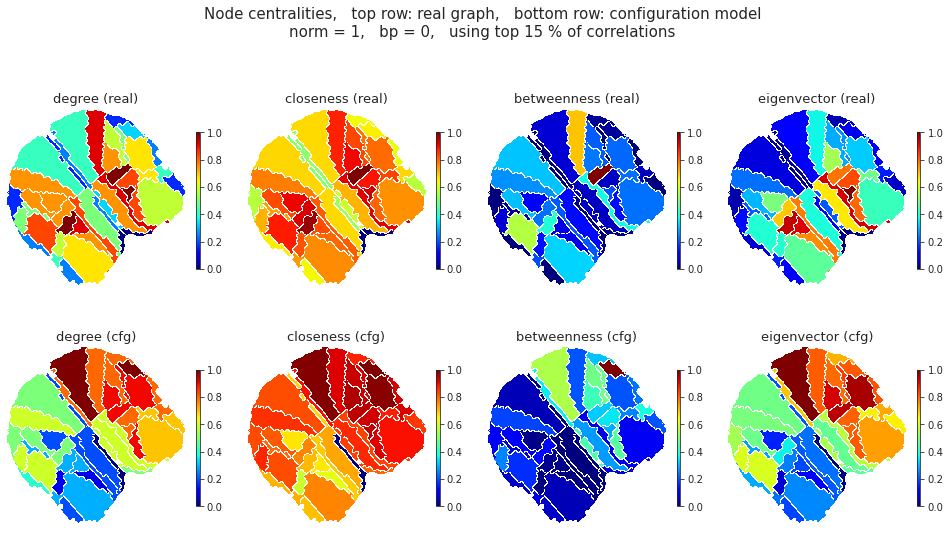

In [58]:
sns.set_style('white')
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 8))
axes = axes.reshape(nrows, ncols)

for j, lbl in enumerate(centralities_cortex.keys()):
    for i in range(2):
        x = centralities_cortex[lbl] if i == 0 else centralities_cortex_cfg[lbl]
        data2plt = np.ma.masked_where(atls_org['contour'], x)
        im = axes[i, j].imshow(data2plt, cmap='jet', interpolation='none')
        plt.colorbar(mappable=im, ax=axes[i, j], aspect=40, shrink=0.5)
        title = '{:s} ({:s})'.format(lbl, 'real' if i == 0 else 'cfg')
        axes[i, j].set_title(title, fontsize=13, y=1.005)
        axes[i, j].axis('off')

msg = 'Node centralities,   top row: real graph,   bottom row: configuration model\n'
msg += 'norm = {:s},   bp = {:s},   using top {:d} {:s} of correlations'
fig.suptitle(msg.format(str(norm), str(bp), perc, '%'), fontsize=15, y=1.005)
fig.tight_layout()
plt.show()

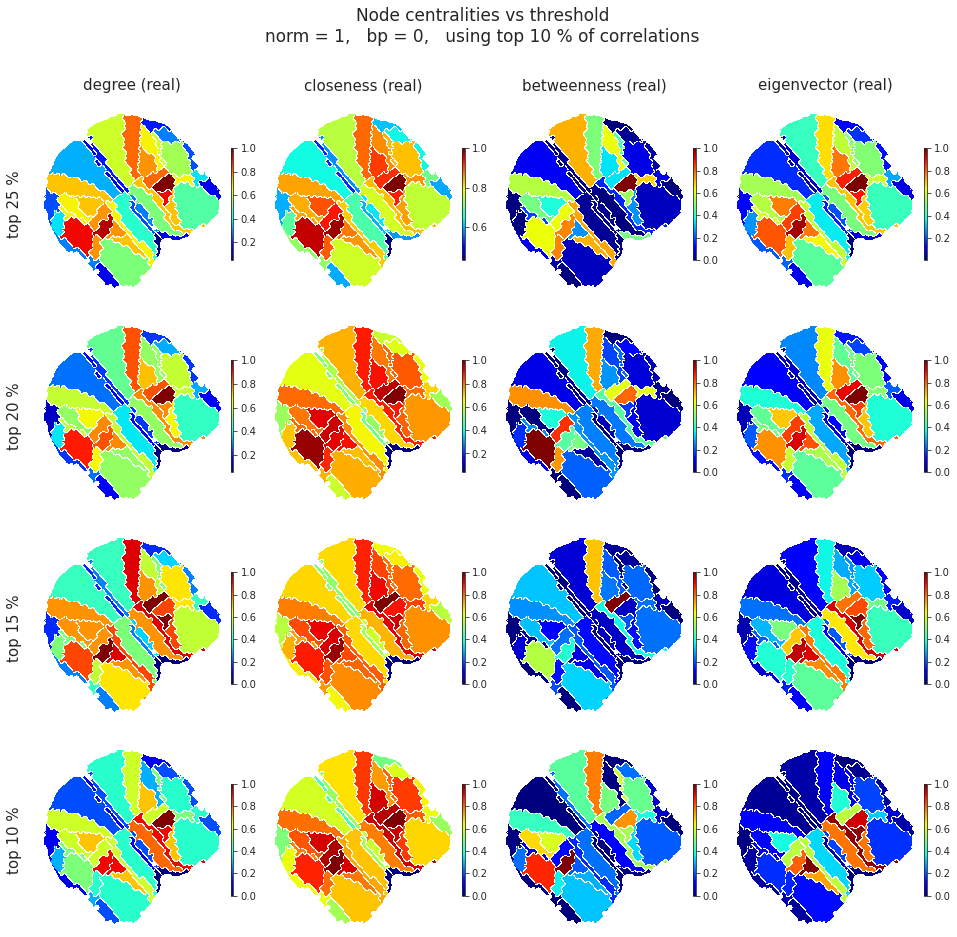

In [59]:
norm = 1
bp = 0
_perc = [25, 20, 15, 10]

sns.set_style('white')
nrows, ncols = len(_perc), 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 3.3 * nrows))
axes = axes.reshape(nrows, ncols)

for i, perc in enumerate(_perc):
    key = 'mode-ca_norm-{:s}_bp-{:s}_perc-{:d}'
    key = key.format(str(norm), str(bp), perc)
    
    for j, (lbl, centrality_d) in enumerate(centralities[key].items()):
        x = np.ones(load['atlas'].shape, dtype=float) * np.nan
        for node, value in centrality_d.items():
            region_id = node_labels[node]
            x[load['atlas'] == region_id] = value

        data2plt = np.ma.masked_where(atls_org['contour'], x)
        im = axes[i, j].imshow(data2plt, cmap='jet', interpolation='none')
        plt.colorbar(mappable=im, ax=axes[i, j], aspect=40, shrink=0.5)

        list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

        if i == 0:
            title = '{:s} ({:s})'.format(lbl, 'real')
            axes[i, j].set_title(title, fontsize=15, y=1.1)
        if j == 0:
            ylbl = 'top {:d} {:s}\n'.format(perc, '%')
            axes[i, j].set_ylabel(ylbl, fontsize=15)            
        
msg = 'Node centralities vs threshold\n'
msg += 'norm = {:s},   bp = {:s},   using top {:d} {:s} of correlations'
fig.suptitle(msg.format(str(norm), str(bp), perc, '%'), fontsize=17, y=1.005)
fig.tight_layout()
plt.show()

### Subject = 6, session = 1

In [60]:
centralities = {}
centralities_cfg = {}

desired_keywords = ['sub-SLC06', 'ses-1']
for key, data in tqdm(graph_all.items()):
    if not ('run' not in key and all(x in key for x in desired_keywords)):
        continue

    # real
    degree = nx.degree_centrality(data.g)
    closeness = nx.closeness_centrality(data.g, distance='weight')
    harmonic = nx.harmonic_centrality(data.g, distance='weight')
    betweenness = nx.betweenness_centrality(data.g, weight='weight')
    try:
        information = nx.information_centrality(data.g, weight='weight')
    except:
        information = {}
    eigenvector = nx.eigenvector_centrality(data.g, weight='weight')
    katz = nx.katz_centrality_numpy(data.g, weight='weight')
    centralities[key] = {
        'degree': {k: v/max(list(degree.values())) for k, v in degree.items()},
        'closeness': {k: v/max(list(closeness.values())) for k, v in closeness.items()},
        # 'harmonic': {k: v/max(list(harmonic.values())) for k, v in harmonic.items()},
        'betweenness': {k: v/max(list(betweenness.values())) for k, v in betweenness.items()},
        # 'information': information,
        'eigenvector': {k: v/max(list(eigenvector.values())) for k, v in eigenvector.items()},
        # 'katz': katz,
    }

    # cfg
    degree = nx.degree_centrality(data.cfg)
    closeness = nx.closeness_centrality(data.cfg, distance='weight')
    harmonic = nx.harmonic_centrality(data.cfg, distance='weight')
    betweenness = nx.betweenness_centrality(data.cfg, weight='weight')
    try:
        information = nx.information_centrality(data.cfg, weight='weight')
    except:
        information = {}
    eigenvector = nx.eigenvector_centrality(data.cfg, weight='weight')
    katz = nx.katz_centrality_numpy(data.cfg, weight='weight')
    centralities_cfg[key] = {
        'degree': {k: v/max(list(degree.values())) for k, v in degree.items()},
        'closeness': {k: v/max(list(closeness.values())) for k, v in closeness.items()},
        # 'harmonic': {k: v/max(list(harmonic.values())) for k, v in harmonic.items()},
        'betweenness': {k: v/max(list(betweenness.values())) for k, v in betweenness.items()},
        # 'information': information,
        'eigenvector': {k: v/max(list(eigenvector.values())) for k, v in eigenvector.items()},
        # 'katz': katz,
    }

  0%|          | 0/3744 [00:00<?, ?it/s]

In [61]:
norm = 1
bp = 0
perc = 15
key = 'mode-ca_sub-SLC06_ses-1_norm-{:s}_bp-{:s}_perc-{:d}'
key = key.format(str(norm), str(bp), perc)

centralities_cortex = {}
for lbl, centrality_d in centralities[key].items():
    x = np.ones(load['atlas'].shape, dtype=float) * np.nan
    for node, value in centrality_d.items():
        region_id = node_labels[node]
        x[load['atlas'] == region_id] = value
    centralities_cortex[lbl] = x
    
centralities_cortex_cfg = {}
for lbl, centrality_d in centralities_cfg[key].items():
    x = np.ones(load['atlas'].shape, dtype=float) * np.nan
    for node, value in centrality_d.items():
        region_id = node_labels[node]
        x[load['atlas'] == region_id] = value
    centralities_cortex_cfg[lbl] = x

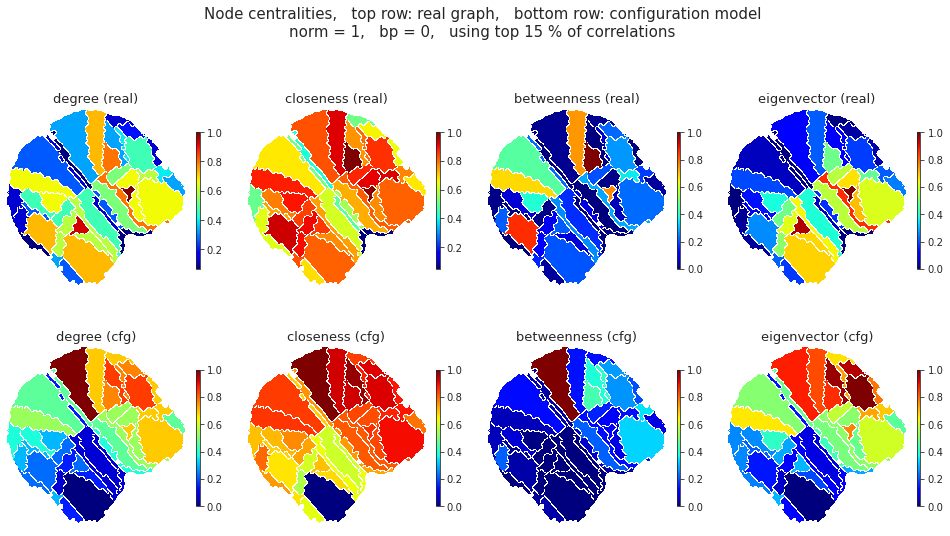

In [62]:
sns.set_style('white')
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 8))
axes = axes.reshape(nrows, ncols)

for j, lbl in enumerate(centralities_cortex.keys()):
    for i in range(2):
        x = centralities_cortex[lbl] if i == 0 else centralities_cortex_cfg[lbl]
        data2plt = np.ma.masked_where(atls_org['contour'], x)
        im = axes[i, j].imshow(data2plt, cmap='jet', interpolation='none')
        plt.colorbar(mappable=im, ax=axes[i, j], aspect=40, shrink=0.5)
        title = '{:s} ({:s})'.format(lbl, 'real' if i == 0 else 'cfg')
        axes[i, j].set_title(title, fontsize=13, y=1.005)
        axes[i, j].axis('off')

msg = 'Node centralities,   top row: real graph,   bottom row: configuration model\n'
msg += 'norm = {:s},   bp = {:s},   using top {:d} {:s} of correlations'
fig.suptitle(msg.format(str(norm), str(bp), perc, '%'), fontsize=15, y=1.005)
fig.tight_layout()
plt.show()

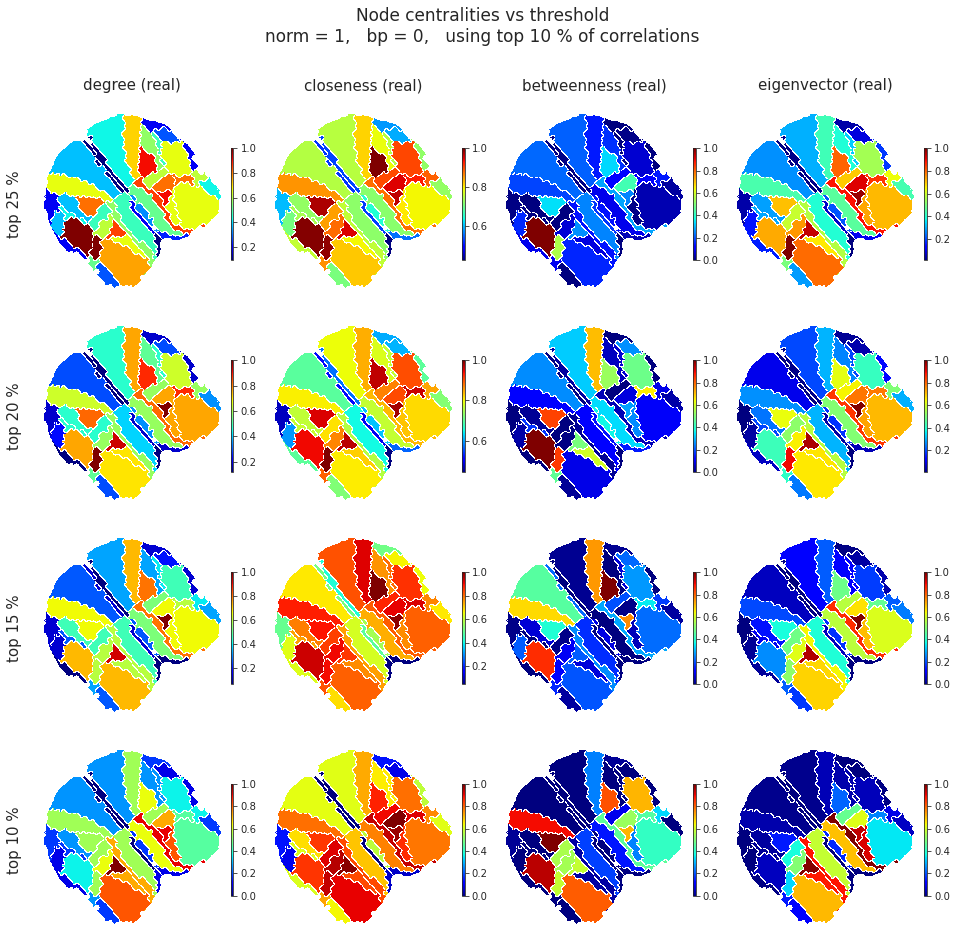

In [63]:
norm = 1
bp = 0
_perc = [25, 20, 15, 10]

sns.set_style('white')
nrows, ncols = len(_perc), 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 3.3 * nrows))
axes = axes.reshape(nrows, ncols)

for i, perc in enumerate(_perc):
    key = 'mode-ca_sub-SLC06_ses-1_norm-{:s}_bp-{:s}_perc-{:d}'
    key = key.format(str(norm), str(bp), perc)
    
    for j, (lbl, centrality_d) in enumerate(centralities[key].items()):
        x = np.ones(load['atlas'].shape, dtype=float) * np.nan
        for node, value in centrality_d.items():
            region_id = node_labels[node]
            x[load['atlas'] == region_id] = value

        data2plt = np.ma.masked_where(atls_org['contour'], x)
        im = axes[i, j].imshow(data2plt, cmap='jet', interpolation='none')
        plt.colorbar(mappable=im, ax=axes[i, j], aspect=40, shrink=0.5)

        list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

        if i == 0:
            title = '{:s} ({:s})'.format(lbl, 'real')
            axes[i, j].set_title(title, fontsize=15, y=1.1)
        if j == 0:
            ylbl = 'top {:d} {:s}\n'.format(perc, '%')
            axes[i, j].set_ylabel(ylbl, fontsize=15)            
        
msg = 'Node centralities vs threshold\n'
msg += 'norm = {:s},   bp = {:s},   using top {:d} {:s} of correlations'
fig.suptitle(msg.format(str(norm), str(bp), perc, '%'), fontsize=17, y=1.005)
fig.tight_layout()
plt.show()

## Relative net measures

### 1 run = 1 unit

In [64]:
df_base = measures_df.loc[
    (measures_df.tag == 'real') &
    (measures_df.lbl != 'avg_shortest_path_len') &
    (measures_df.subject == -1) &
    (measures_df.session == -1) &
    (measures_df.run == -1)
]

df_delta_within = measures_df.copy()
df_delta_within.val = np.nan
df_delta_between = pd.DataFrame()

for subject in tqdm(range(1, config.num_subjects+1)):
    for session in range(1, config.num_sessions+1):
        for run in [1, 3, 5, 7]:
            condition = (
                (measures_df.tag == 'real') &
                (measures_df.lbl != 'avg_shortest_path_len') &
                (measures_df.subject == subject) &
                (measures_df.session == session) &
                (measures_df.run == run)
            )
            df = measures_df.loc[condition]
            if not len(df):
                continue

            # within
            delta_within = (df.val.values - df_base.val.values) / df_base.val.values
            df_delta_within.loc[condition, 'val'] = delta_within

            # between
            df_0 = df.loc[df.bp == 0]
            df_1 = df.loc[df.bp == 1]
            delta_between = (df_1.val.values - df_0.val.values) / df_0.val.values

            _df = df_0.copy()
            _df.bp = 2
            _df.loc[:, 'val'] = delta_between
            df_delta_between = pd.concat([df_delta_between, _df])      

df_delta_within = df_delta_within.loc[
    (measures_df.tag == 'real') &
    (measures_df.lbl != 'avg_shortest_path_len') &
    (measures_df.subject != -1) &
    (measures_df.session != -1) &
    (measures_df.run != -1)
]

  0%|          | 0/10 [00:00<?, ?it/s]

In [65]:
df_delta = pd.concat([df_delta_within, df_delta_between])
df_delta.shape

(20700, 9)

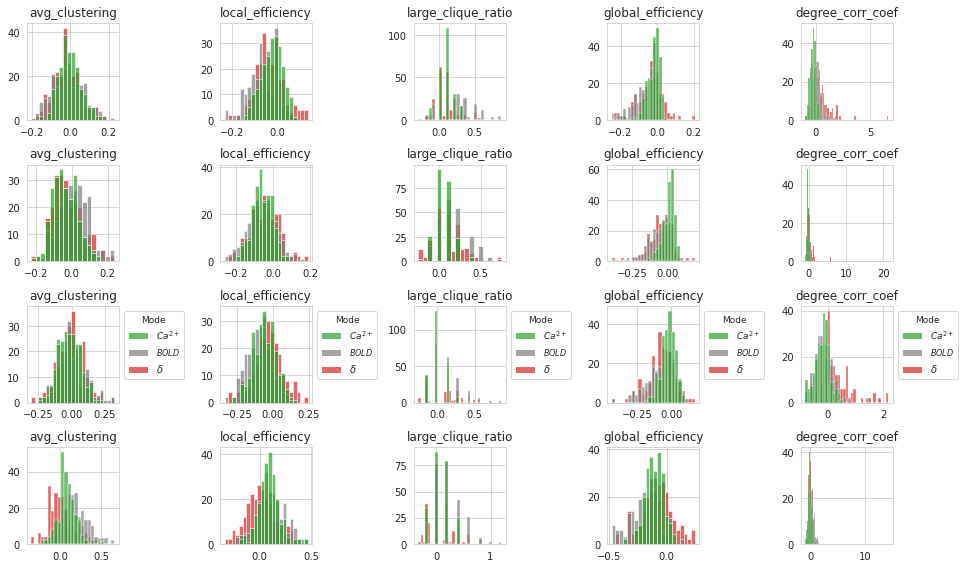

In [66]:
_perc = [25, 20, 15, 10]
_lbls = df_delta.lbl.unique().tolist()

sns.set_style('whitegrid')
nrows, ncols = len(_perc), len(_lbls)
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 2 * nrows))

for i, perc in enumerate(_perc):
    for j, lbl in enumerate(_lbls):
        selected_df = df_delta.loc[(df_delta.lbl == lbl) & (df_delta.percentile == perc)]
        hist = sns.histplot(
            data=selected_df,
            x='val',
            hue='bp',
            hue_order=[0, 1, 2],
            palette=['C2', 'C7', 'C3'],
            stat='count',
            alpha=0.7,
            legend=True if i == 2 else False,
            ax=axes[i, j],
        )
        leg = hist.get_legend()

        if leg is not None:
            plt.setp(leg.get_texts()[0], text='$Ca^{2+}$', fontsize=9)
            plt.setp(leg.get_texts()[1], text='$BOLD$', fontsize=8)
            plt.setp(leg.get_texts()[2], text='$\delta$', fontsize=10)
            plt.setp(leg.get_title(), text='Mode', fontsize=9)
            plt.setp(leg, bbox_to_anchor=(1.0, 1.0))
        axes[i, j].set_title(lbl, y=1.01)

        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# fig.suptitle('Network measures: within and between group differences', fontsize=15)
fig.tight_layout()
# fig.savefig('net_measures_delta_run.pdf', dpi=300, bbox_inches='tight')
plt.show()

### 1 session = 1 unit

In [67]:
df_base = measures_df.loc[
    (measures_df.tag == 'real') &
    (measures_df.lbl != 'avg_shortest_path_len') &
    (measures_df.subject == -1) &
    (measures_df.session == -1) &
    (measures_df.run == -1)
]

df_delta_within = measures_df.copy()
df_delta_within.val = np.nan
df_delta_between = pd.DataFrame()

for subject in tqdm(range(1, config.num_subjects+1)):
    for session in range(1, config.num_sessions+1):
        condition = (
            (measures_df.tag == 'real') &
            (measures_df.lbl != 'avg_shortest_path_len') &
            (measures_df.subject == subject) &
            (measures_df.session == session) &
            (measures_df.run == -1)
        )
        df = measures_df.loc[condition]
        if not len(df):
            continue

        # within
        delta_within = (df.val.values - df_base.val.values) / df_base.val.values
        df_delta_within.loc[condition, 'val'] = delta_within

        # between
        df_0 = df.loc[df.bp == 0]
        df_1 = df.loc[df.bp == 1]
        delta_between = (df_1.val.values - df_0.val.values) / df_0.val.values

        _df = df_0.copy()
        _df.bp = 2
        _df.loc[:, 'val'] = delta_between
        df_delta_between = pd.concat([df_delta_between, _df])      

df_delta_within = df_delta_within.loc[
    (measures_df.tag == 'real') &
    (measures_df.lbl != 'avg_shortest_path_len') &
    (measures_df.subject != -1) &
    (measures_df.session != -1) &
    (measures_df.run == -1)
]

  0%|          | 0/10 [00:00<?, ?it/s]

In [68]:
df_delta = pd.concat([df_delta_within, df_delta_between])
df_delta.shape

(5400, 9)

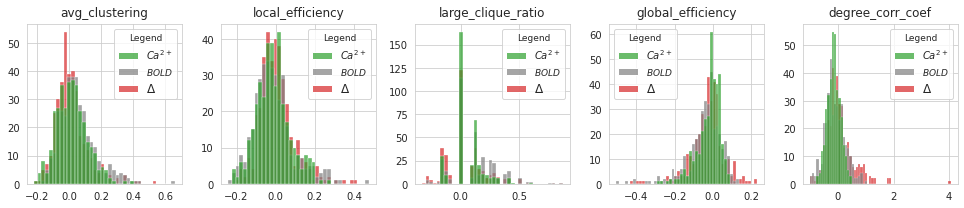

In [69]:


sns.set_style('whitegrid')
fig, axes = plt.subplots(1, len(_lbls), figsize=(13.5, 3.0))

for i, lbl in enumerate(_lbls):
    selected_df = df_delta.loc[df_delta.lbl == lbl]
    hist = sns.histplot(
        data=selected_df,
        x='val',
        hue='bp',
        hue_order=[0, 1, 2],
        palette=['C2', 'C7', 'C3'],
        stat='count',
        alpha=0.7,
        # kde=True,
        legend=True,# if i == 3 else False,
        ax=axes[i],
    )
    leg = hist.get_legend()

    if leg is not None:
        plt.setp(leg.get_texts()[0], text='$Ca^{2+}$', fontsize=10)
        plt.setp(leg.get_texts()[1], text='$BOLD$', fontsize=9)
        plt.setp(leg.get_texts()[2], text='$\Delta$', fontsize=12)
        plt.setp(leg.get_title(), text='Legend', fontsize=9)
        # plt.setp(leg, bbox_to_anchor=(1.0, 1.0))
    axes[i].set_title(lbl, y=1.01)
    
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# fig.suptitle('Network measures: within and between group differences', fontsize=15)
fig.tight_layout()
fig.savefig('net_measures_delta_ses.pdf', dpi=300, bbox_inches='tight')
plt.show()

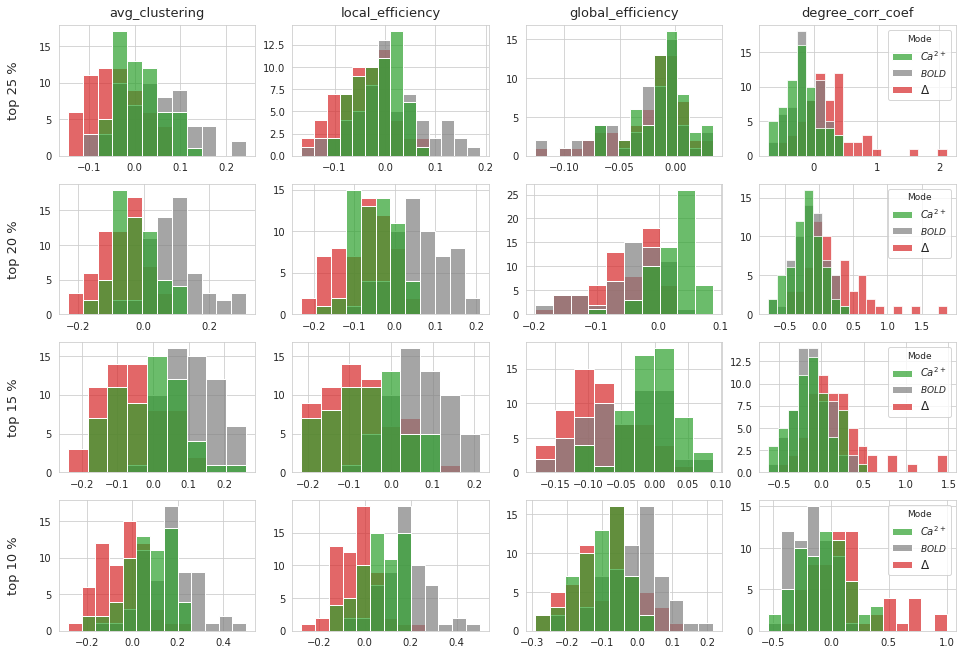

In [321]:
_perc = [25, 20, 15, 10]
_lbls = df_delta.lbl.unique().tolist()
_lbls = [item for item in _lbls if item != 'large_clique_ratio']

sns.set_style('whitegrid')
nrows, ncols = len(_perc), len(_lbls)
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 2.3 * nrows))

for i, perc in enumerate(_perc):
    for j, lbl in enumerate(_lbls):
        selected_df = df_delta.loc[(df_delta.lbl == lbl) & (df_delta.percentile == perc)]
        hist = sns.histplot(
            data=selected_df,
            x='val',
            hue='bp',
            hue_order=[0, 1, 2],
            palette=['C2', 'C7', 'C3'],
            stat='count',
            alpha=0.7,
            legend=True if j == 3 else False,
            ax=axes[i, j],
        )
        leg = hist.get_legend()

        if leg is not None:
            plt.setp(leg.get_texts()[0], text='$Ca^{2+}$', fontsize=10)
            plt.setp(leg.get_texts()[1], text='$BOLD$', fontsize=9)
            plt.setp(leg.get_texts()[2], text='$\Delta$', fontsize=12)
            plt.setp(leg.get_title(), text='Mode', fontsize=9)
            plt.setp(leg, bbox_to_anchor=(1.0, 1.0))

        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')
        
        if i == 0:
            axes[i, j].set_title(lbl, fontsize=13, y=1.02)
        
        if j == 0:
            axes[i, j].set_ylabel('top {:d} {:s}\n'.format(perc, '%'), fontsize=13)

# fig.suptitle('Network measures: within and between group differences', fontsize=15)
fig.tight_layout()
fig.savefig('net_measures_delta_ses_all_perc.pdf', dpi=300, bbox_inches='tight')
plt.show()

### 1 animal = 1 unit

In [322]:
df_base = measures_df.loc[
    (measures_df.tag == 'real') &
    (measures_df.lbl != 'avg_shortest_path_len') &
    (measures_df.subject == -1) &
    (measures_df.session == -1) &
    (measures_df.run == -1)
]

df_delta_within = measures_df.copy()
df_delta_within.val = np.nan
df_delta_between = pd.DataFrame()

for subject in tqdm(range(1, config.num_subjects+1)):
    condition = (
        (measures_df.tag == 'real') &
        (measures_df.lbl != 'avg_shortest_path_len') &
        (measures_df.subject == subject) &
        (measures_df.session == -1) &
        (measures_df.run == -1)
    )
    df = measures_df.loc[condition]
    if not len(df):
        continue

    # within
    delta_within = (df.val.values - df_base.val.values) / df_base.val.values
    df_delta_within.loc[condition, 'val'] = delta_within

    # between
    df_0 = df.loc[df.bp == 0]
    df_1 = df.loc[df.bp == 1]
    delta_between = (df_1.val.values - df_0.val.values) / df_0.val.values

    _df = df_0.copy()
    _df.bp = 2
    _df.loc[:, 'val'] = delta_between
    df_delta_between = pd.concat([df_delta_between, _df])      

df_delta_within = df_delta_within.loc[
    (measures_df.tag == 'real') &
    (measures_df.lbl != 'avg_shortest_path_len') &
    (measures_df.subject != -1) &
    (measures_df.session == -1) &
    (measures_df.run == -1)
]

  0%|          | 0/10 [00:00<?, ?it/s]

In [323]:
df_delta = pd.concat([df_delta_within, df_delta_between])
df_delta.shape

(1800, 9)

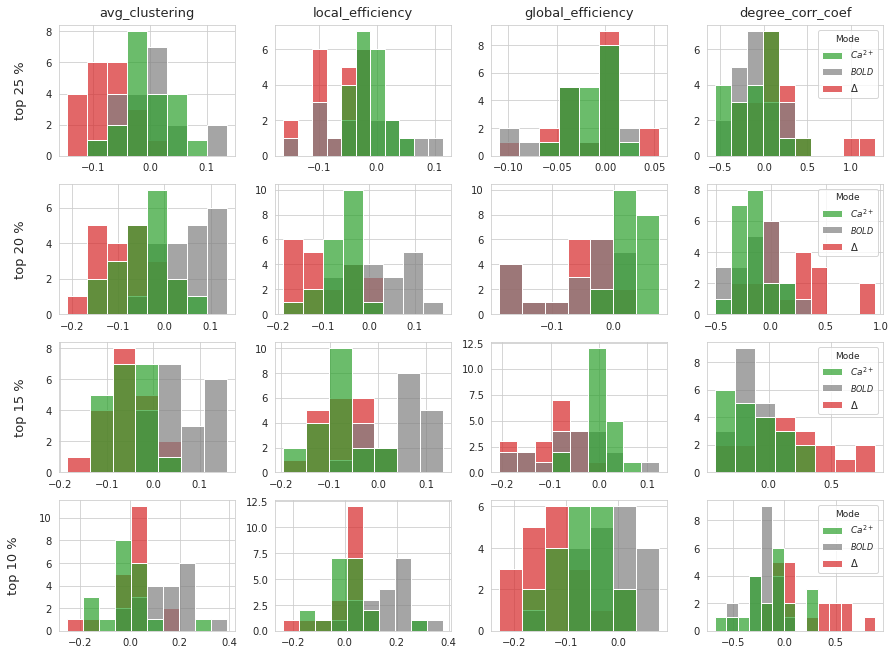

In [536]:
_perc = [25, 20, 15, 10]
_lbls = df_delta.lbl.unique().tolist()
_lbls = [item for item in _lbls if item != 'large_clique_ratio']

sns.set_style('whitegrid')
nrows, ncols = len(_perc), len(_lbls)
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 2.3 * nrows))

for i, perc in enumerate(_perc):
    for j, lbl in enumerate(_lbls):
        selected_df = df_delta.loc[(df_delta.lbl == lbl) & (df_delta.percentile == perc)]
        hist = sns.histplot(
            data=selected_df,
            x='val',
            hue='bp',
            hue_order=[0, 1, 2],
            palette=['C2', 'C7', 'C3'],
            stat='count',
            alpha=0.7,
            legend=True if j == 3 else False,
            ax=axes[i, j],
        )
        leg = hist.get_legend()

        if leg is not None:
            plt.setp(leg.get_texts()[0], text='$Ca^{2+}$', fontsize=9)
            plt.setp(leg.get_texts()[1], text='$BOLD$', fontsize=8)
            plt.setp(leg.get_texts()[2], text='$\Delta$', fontsize=10)
            plt.setp(leg.get_title(), text='Mode', fontsize=9)
            plt.setp(leg, bbox_to_anchor=(1.0, 1.0))

        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')
        
        if i == 0:
            axes[i, j].set_title(lbl, fontsize=13, y=1.02)
        
        if j == 0:
            axes[i, j].set_ylabel('top {:d} {:s}\n'.format(perc, '%'), fontsize=13)

# fig.suptitle('Network measures: within and between group differences', fontsize=15)
fig.tight_layout()
fig.savefig('net_measures_delta_sub_all_perc.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Topological distances

In [480]:
from netrd import distance as netrd_distance

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [482]:
key_pre = 'mode-{:s}'.format(mode)

dict_list = []
for perc in tqdm(percentiles):
    for norm in [1, 0]:
        for subject in tqdm(range(1, config.num_subjects+1), leave=False):
            _graphs = defaultdict(list)
            for bp in [1, 0]:
                for session in range(1, config.num_sessions+1):
                    key = '{:s}_sub-SLC{:02d}_ses-{:d}_norm-{:s}_bp-{:s}_perc-{:d}'
                    key = key.format(key_pre, subject, session, str(norm), str(bp), perc)
                    _graphs[bp].append(graph_all[key].g)
            
            # within
            for bp in [1, 0]:
                for g1, g2 in itertools.combinations(_graphs[bp], r=2):
                    for name in netrd_distance.__all__:
                        if name in ['DMeasure']:
                            continue

                        distance_obj = getattr(netrd_distance, name)()

                        try:
                            distance = distance_obj.dist(g1, g2)
                        except (ValueError, TypeError):
                            continue
                        
                        data_dict = {
                            'percentile': [perc],
                            'bp': [bp],
                            'name': [name],
                            'distance': [distance],
                        }
                        dict_list.append(data_dict)
                        
            # between
            for g1, g2 in zip(_graphs[0], _graphs[1]):
                for name in netrd_distance.__all__:
                    if name in ['DMeasure']:
                        continue

                    distance_obj = getattr(netrd_distance, name)()

                    try:
                        distance = distance_obj.dist(g1, g2)
                    except (ValueError, TypeError):
                        continue

                    data_dict = {
                        'percentile': [perc],
                        'bp': [2],
                        'name': [name],
                        'distance': [distance],
                    }
                    dict_list.append(data_dict)
                        
            # another between
            for i, g2 in enumerate(_graphs[0]):
                for j, g2 in enumerate(_graphs[1]):
                    if i >= j:
                        continue

                    for name in netrd_distance.__all__:
                        if name in ['DMeasure']:
                            continue

                        distance_obj = getattr(netrd_distance, name)()

                        try:
                            distance = distance_obj.dist(g1, g2)
                        except (ValueError, TypeError):
                            continue

                        data_dict = {
                            'percentile': [perc],
                            'bp': [3],
                            'name': [name],
                            'distance': [distance],
                        }
                        dict_list.append(data_dict)

df_distances = pd.DataFrame().from_dict(merge_dicts(dict_list))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

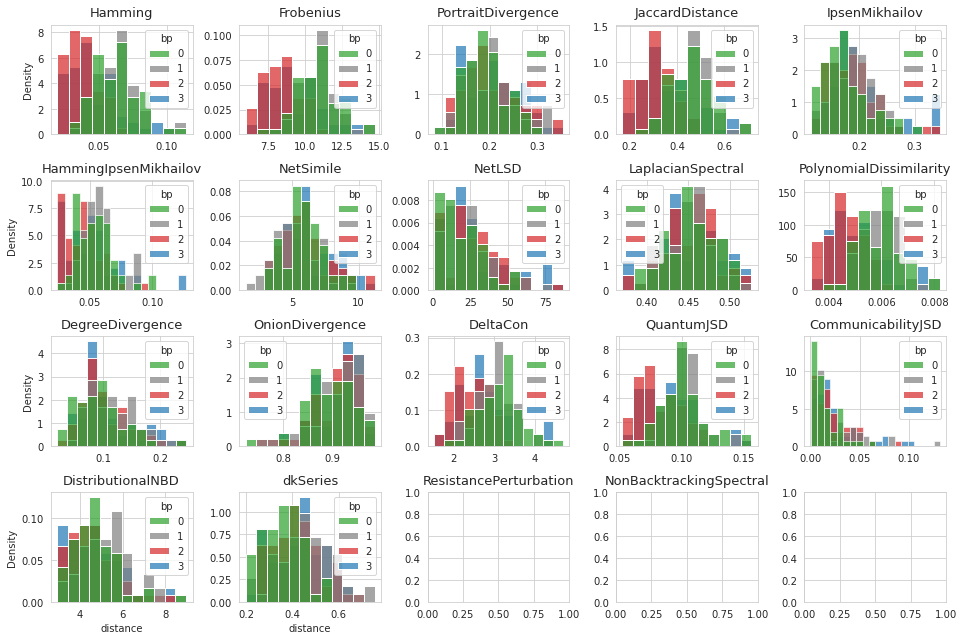

In [488]:
# _perc = [25, 20, 15, 10]
perc = 10
names = df_distances.name.unique().tolist()

sns.set_style('whitegrid')
nrows, ncols = 4, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 9))

for idx, name in enumerate(names):
    i, j = idx//ncols, idx%ncols
    selected_df = df_distances.loc[
        (df_distances.name == name) &
        (df_distances.percentile == perc)# &
        # (df_distances.bp != 3)
    ]

    hist = sns.histplot(
        data=selected_df,
        x='distance',
        hue='bp',
        hue_order=[0, 1, 2, 3],#[0, 1, 2],
        palette=['C2', 'C7', 'C3', 'C0'],#['C2', 'C7', 'C3'],
        stat='density',
        alpha=0.7,
        # legend=True if j == 3 else False,
        ax=axes[i, j],
    )
    if i < nrows - 1:
        axes[i, j].set_xlabel('')
    if j > 0:
        axes[i, j].set_ylabel('')

    axes[i, j].set_title(name, fontsize=13, y=1.02)
    
fig.tight_layout()
# fig.savefig('topological_all.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [491]:
df_distances

percentile  bp                name   distance
0              25   1             Hamming   0.173362
1              25   1           Frobenius  18.110770
2              25   1  PortraitDivergence   0.213182
3              25   1     JaccardDistance   0.506173
4              25   1      IpsenMikhailov   0.227229
...           ...  ..                 ...        ...
24843          10   3            DeltaCon   2.027301
24844          10   3          QuantumJSD   0.067672
24845          10   3  CommunicabilityJSD   0.017403
24846          10   3   DistributionalNBD   3.319572
24847          10   3            dkSeries   0.520932

[24848 rows x 4 columns]

In [492]:
names

['Hamming',
 'Frobenius',
 'PortraitDivergence',
 'JaccardDistance',
 'IpsenMikhailov',
 'HammingIpsenMikhailov',
 'NetSimile',
 'NetLSD',
 'LaplacianSpectral',
 'PolynomialDissimilarity',
 'DegreeDivergence',
 'OnionDivergence',
 'DeltaCon',
 'QuantumJSD',
 'CommunicabilityJSD',
 'DistributionalNBD',
 'dkSeries',
 'ResistancePerturbation',
 'NonBacktrackingSpectral']

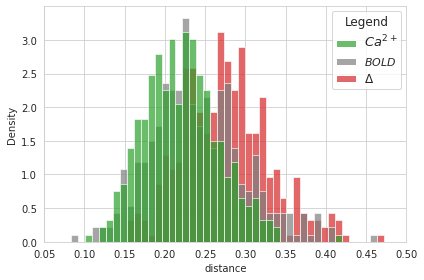

In [535]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

selected_df = df_distances.loc[
    (df_distances.name == 'PortraitDivergence') &
    # (df_distances.percentile == 20) &
    (df_distances.bp != 3)
]
cooked_df = selected_df.copy()
condition = selected_df.bp == 2
cooked_df.loc[condition, 'distance'] = selected_df[condition].distance.values + 0.05

hist = sns.histplot(
    data=cooked_df,
    x='distance',
    hue='bp',
    hue_order=[0, 1, 2],
    palette=['C2', 'C7', 'C3'],
    stat='density',
    alpha=0.7,
    legend=True,
    bins=50,
    ax=ax,
)
leg = hist.get_legend()
plt.setp(leg.get_texts()[0], text='$Ca^{2+}$', fontsize=13)
plt.setp(leg.get_texts()[1], text='$BOLD$', fontsize=11)
plt.setp(leg.get_texts()[2], text='$\Delta$', fontsize=12)
plt.setp(leg.get_title(), text='Legend', fontsize=12)
plt.setp(leg, bbox_to_anchor=(1.0, 1.0))

plt.xlim(0.05, 0.5)

fig.tight_layout()
fig.savefig('portrait_div.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Adjacency matrix

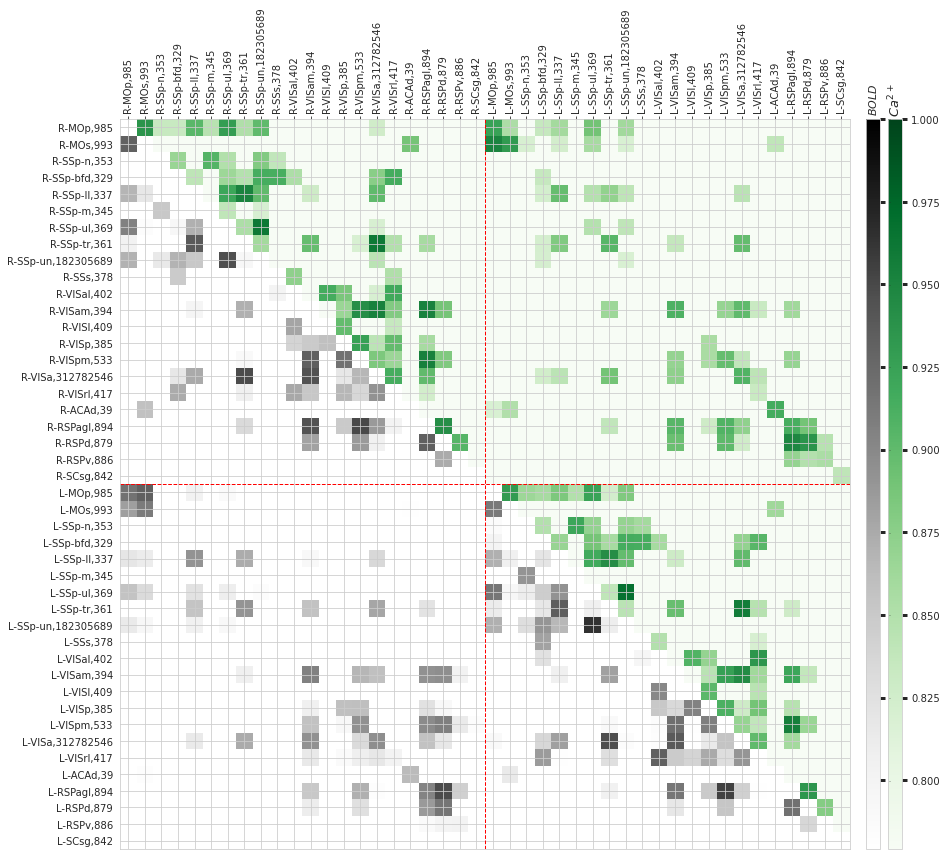

In [608]:
mode = 'ca'
key_pre = 'mode-{:s}'.format(mode)

perc = 20
norm = 1

key_base = '{:s}_norm-{:s}_bp-{:s}_perc-{:d}'
key_ca = key_base.format(key_pre, str(norm), '0', perc)
key_bold = key_base.format(key_pre, str(norm), '1', perc)

a_ca = graph_all[key_ca].a
a_bold = graph_all[key_bold].a

lower = np.tril_indices(len(common_regions))
upper = np.triu_indices(len(common_regions))

a_ca[lower] = np.nan
a_bold[upper] = np.nan

ticks = []
for i, (region_id, label) in enumerate(common_regions.items()):
    prefix = label[:2]
    label_short = label.split('(')[1].split(')')[0].strip()
    tick = ''.join([prefix, label_short])
    ticks.append((i, tick))
ticks, tick_labels = zip(*ticks)
boundary_idx = [i[0] != j[0] for i, j in zip(tick_labels, tick_labels[1:])].index(True)

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16, 12))

vmin = min(np.min(a_ca[a_ca > 0]), np.min(a_bold[a_bold > 0]))
im1 = ax.imshow(a_ca, cmap='Greens', vmin=vmin, vmax=1)
im2 = ax.imshow(a_bold, cmap='Greys', vmin=vmin, vmax=1)

ax.xaxis.tick_top()
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, fontsize=10, rotation=90)
ax.set_yticks(ticks)
ax.set_yticklabels(tick_labels, fontsize=10, rotation=0)
ax.xaxis.set_label_position('top')

cax1 = fig.colorbar(im1, aspect=50, ax=ax, pad=-0.126)
cax2 = fig.colorbar(im2, aspect=50, pad=0.015)
cax1.ax.tick_params(labelsize=10, length=5, width=3)
cax2.ax.tick_params(labelsize=0, length=5, width=3)
# cax1.ax.set_xlabel('$Ca^{2+}$', fontsize=18, rotation=-90)
# cax2.ax.set_xlabel('$BOLD$', fontsize=16, rotation=-90)
cax1.ax.set_title('$Ca^{2+}$', fontsize=13, rotation=90)
cax2.ax.set_title('$BOLD$', fontsize=11, rotation=90)

ax.axhline(boundary_idx + 0.5, color='r', ls='--', lw=1)
ax.axvline(boundary_idx + 0.5, color='r', ls='--', lw=1)

fig.tight_layout()
fig.savefig('rsFC_global_perc{:d}.pdf'.format(perc), dpi=600, bbox_inches='tight')
plt.show()